![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    Flux Processing Chain
</b>
</span>

---
**Notebook version**: `8` (3 Sep 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **BACKGROUND**

- This notebook demonstrates part of the flux post-processing used for fluxes from Swiss FluxNet research stations
- For a description of the different flux levels, see [Flux Processing Chain](https://www.swissfluxnet.ethz.ch/index.php/data/ecosystem-fluxes/flux-processing-chain/)
- Flux calculations (Level-1) were done in a previous step
- This notebook uses the calculated fluxes (Level-1) and applies several post-processing steps:
    - Quality flag extension (Level-2)
    - Storage correction (Level-3.1)
    - Outlier removal (Level-3.2)
- Other flux levels are currently not produced in this example:
    - Gap-filling (Level-4.1)
    - NEE Partitioning (Level-4.2)
 
**Important**
- Variable names in the input files need to follow the [FLUXNET convention](https://fluxnet.org/data/fluxnet2015-dataset/fullset-data-product/)

</br>

# **USER SETTINGS**

## Flux variable
`FLUXVAR` is the name of the flux variable in the data files. In the EddyPro `_fluxnet_` output files, the flux variables we primarily use are:
  - `FC` ... CO2 flux, becomes `NEE` after storage correction (Level-3.1)
  - `LE` ... Latent heat flux (water)
  - `H` ... Sensible heat flux
  - `FN2O` ... Nitrous oxide flux
  - `FCH4` ... Methane flux
  
There are more flux variables in the output file, but we rarely need them:
  - `FH2O` ... H2O flux, very important but it is the same as `ET` and `LE` but with different units
  - `ET` ... Evapotranspiration, very important but it is the same as `FH2O` and `LE` but with different units. We can easily calculte `ET` later from `LE`, e.g. in `ReddyProc`.
  - `TAU` ... Momentum flux, a measure of the turbulent transfer of momentum between the land surface and the atmosphere

Set the name of the flux variable in the output file(s), must use the FLUXNET naming convention, e.g. FC, FH2O, LE, ET, H, FN2O, FCH4:

In [80]:
FLUXVAR = "FC"

## Site location
- Latitude and longitude of the site where data were recorded. This info is mainly used to calculate potential radiation, which is then used to divide the dataset into daytime and nighttime data.
- UTC offset of the timestamp used in the dataset, important for calculating potential radiation for this location with the correct timestamp.

In [81]:
SITE_LAT = 47.210227
SITE_LON = 8.410645
UTC_OFFSET = 1  # Time stamp offset in relation to UTC, e.g. 1 for UTC+01:00 (CET), important for the calculation of potential radiation for detecting daytime and nighttime

## Daytime/nighttime
- Threshold for potential radiation in `W m-2`, records below threshold are considered nighttime

In [82]:
NIGHTTIME_THRESHOLD = 50

## Quality requirements
- The new default setting is to only accept highest-quality fluxes where the overall quality flag `QCF` = 0
- This strict quality-filtering removes a lot of data points, but running random forest gap-filling with only the highest-quality records yields far better model results in terms of scoring (higher r2, lower error)

In [83]:
DAYTIME_ACCEPT_QCF_BELOW = 1
NIGHTTIMETIME_ACCEPT_QCF_BELOW = 1

## Source data
- It is possible to load data from (multiple) EddyPro _fluxnet_ output files (data from files will be merged), or directly from one single [parquet](https://parquet.apache.org/) file.
- parquet files are a good option for large datasets because they load and save much faster than when using conventional CSV files.
- For large datasets, it makes sense to first load and merge data from the original EddyPro _fluxnet_ output files, then convert the merged data to one single parquet file and then use this file as input file.

If you want to search for EddyPro _fluxnet_ files in specific locations, you can specify multiple folders here:

In [84]:
SOURCEDIRS = [
    r'L:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\cha_fp2024.1_2005-2023\0_data\RESULTS-IRGA-Level-1_fluxnet_2005-2023'
]  # Folders where input file(s) are located

If you want to load data directly from a specific parquet file, you can specify its name and location here:

In [85]:
SOURCEDIR = r"F:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\20_FLUXES_L1_IRGA_preparation"
FILENAME = r"23.1_CH-CHA_IRGA_Level-1_eddypro_fluxnet_2005-2023_availableVars_meteo7.parquet"
from pathlib import Path

FILEPATH = Path(SOURCEDIR) / FILENAME
print(f"Data will be loaded from the following file:\n{FILEPATH}")

Data will be loaded from the following file:
F:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\20_FLUXES_L1_IRGA_preparation\23.1_CH-CHA_IRGA_Level-1_eddypro_fluxnet_2005-2023_availableVars_meteo7.parquet


</br>

# **IMPORTS**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [86]:

import importlib.metadata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from diive.pkgs.flux.hqflux import analyze_highest_quality_flux
from diive.core.io.files import save_parquet, load_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.pkgs.fluxprocessingchain.fluxprocessingchain import FluxProcessingChain
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.81.0


</br>

# **DOCSTRING** for `FluxProcessingChain`

In [87]:
help(FluxProcessingChain)

Help on class FluxProcessingChain in module diive.pkgs.fluxprocessingchain.fluxprocessingchain:

class FluxProcessingChain(builtins.object)
 |  FluxProcessingChain(maindf: pandas.core.frame.DataFrame, fluxcol: str, site_lat: float, site_lon: float, utc_offset: int, nighttime_threshold: float = 50)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, maindf: pandas.core.frame.DataFrame, fluxcol: str, site_lat: float, site_lon: float, utc_offset: int, nighttime_threshold: float = 50)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  analyze_highest_quality_flux(self, showplot: bool = True)
 |  
 |  finalize_level2(self, nighttime_threshold: int = 50, daytime_accept_qcf_below: int = 2, nighttimetime_accept_qcf_below: int = 2)
 |      Calculate overall quality flag QCF after Level-2
 |  
 |  finalize_level31(self)
 |  
 |  finalize_level32(self, nighttime_threshold: int = 50, daytime_accept_qcf_below: int = 2, nighttimetime_accept_qcf_below: int = 2)
 |     

</br>

</br>

# **LOAD DATA** (2 options)

## Option 1: Load data from single or multiple output files
- Used to read data from the EddyPro _fluxnet_ output files

In [88]:
# ep = LoadEddyProOutputFiles(sourcedir=SOURCEDIRS, filetype=FILETYPE)

In [89]:
# ep.searchfiles()

In [90]:
# ep.loadfiles()

In [91]:
# maindf = ep.maindf
# metadata = ep.metadata

</br>

## Option 2: Load data from `parquet` file
- Used to continue a previous session where another flux variable was already post-processed
- For example, if you have already post-processed CO2 flux and now want to post-process H2O flux
- Also detects time resolution of time series, this info was lost when saving to the parquet file

In [92]:
maindf = load_parquet(filepath=FILEPATH)

Loaded .parquet file F:\Sync\luhk_work\20 - CODING\29 - WORKBENCH\dataset_cha_fp2024_2005-2023\20_FLUXES_L1_IRGA_preparation\23.1_CH-CHA_IRGA_Level-1_eddypro_fluxnet_2005-2023_availableVars_meteo7.parquet (0.519 seconds). Detected time resolution of <30 * Minutes> / 30min 


In [93]:
# Use one year of data
maindf = maindf.loc[maindf.index.year >= 2020].copy()
# maindf = maindf.loc[(maindf.index.year == 2017) | (maindf.index.year == 2018)].copy()
# maindf = maindf.loc[(maindf.index.month >= 5) & (maindf.index.month <= 6)].copy()

</br>

## Check data

In [94]:
maindf

AIR_MV  AIR_DENSITY  AIR_RHO_CP   AIR_CP  AOA_METHOD  AXES_ROTATION_METHOD    BOWEN  BURBA_METHOD  BADM_LOCATION_LAT  BADM_LOCATION_LONG  BADM_LOCATION_ELEV  BADM_HEIGHTC  BADM_INST_SAMPLING_INT  BADM_INST_AVERAGING_INT  BADM_INST_HEIGHT_SA  BADM_SA_OFFSET_NORTH  BADM_INSTPAIR_NORTHWARD_SEP_GA_CO2  BADM_INSTPAIR_EASTWARD_SEP_GA_CO2  BADM_INSTPAIR_HEIGHT_SEP_GA_CO2  BADM_INSTPAIR_NORTHWARD_SEP_GA_H2O  BADM_INSTPAIR_EASTWARD_SEP_GA_H2O  BADM_INSTPAIR_HEIGHT_SEP_GA_H2O  CUSTOM_FILTER_NR   CO2_NR  CO2_MEAS_TYPE  ...  W_SPIKE_NREX  W_ABSLIM_NREX  W_VM97_TEST  W_LGD     W_KID   W_ZCD  W_ITC  W_ITC_TEST  WBOOST_APPLIED  WPL_APPLIED        ZL  ZL_UNCORR  LW_IN_T1_2_1  PA_GF1_0.9_1  FLAG_PA_GF1_0.9_1_ISFILLED  PPFD_IN_T1_2_2  FLAG_PPFD_IN_T1_2_2_ISFILLED  VPD_T1_2_1  FLAG_VPD_T1_2_1_ISFILLED  SW_IN_T1_2_1  FLAG_SW_IN_T1_2_1_ISFILLED  TA_T1_2_1  FLAG_TA_T1_2_1_ISFILLED   RH_T1_2_1  FLAG_RH_T1_2_1_ISFILLED
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         ...                                                                                                                                                                                                                                                                                                                                                                                                       
2020-01-01 00:15:00  0.023510      1.22908     1239.58  1008.54         0.0                   1.0  1.48762           0.0            47.2102             8.41064               393.0           0.5                    20.0                     30.0                 2.41                   7.0                                14.0                               31.0                              1.0                                14.0                               31.0                              1.0           36000.0  36000.0            2.0  ...           0.0            0.0  800000011.0    0.0   5.62304  1006.0   32.0         3.0             0.0          1.0 -1.911930  -1.990720    309.090500    986.430000                         0.0             0.0                           0.0    0.000000                       0.0           0.0                         0.0  -0.099320                      0.0  100.000000                      0.0
2020-01-01 00:45:00  0.023510      1.22912     1239.62  1008.54         0.0                   1.0  1.59377           0.0            47.2102             8.41064               393.0           0.5                    20.0                     30.0                 2.41                   7.0                                14.0                               31.0                              1.0                                14.0                               31.0                              1.0           36000.0  35989.0            2.0  ...           0.0            0.0  800000011.0    0.0   6.19985  1170.0    9.0         1.0             0.0          1.0 -0.659449  -0.685230    309.130000    986.082600                         0.0             0.0                           0.0    0.000000                       0.0           0.0                         0.0  -0.107806                      0.0  100.000000                      0.0
2020-01-01 01:15:00  0.023505      1.22938     1239.87  1008.53         0.0                   1.0  2.22829           0.0            47.2102             8.41064               393.0           0.5                    20.0                     30.0                 2.41                   7.0          

In [95]:
sstats(maindf[FLUXVAR])

FC
STARTDATE       2020-01-01 00:15
ENDDATE         2024-01-01 00:45
PERIOD        1461 days 00:30:00
NOV                        63659
MISSING                     6471
MISSING_PERC             9.22715
MEAN                   -2.438999
MEDIAN                 -0.704257
SD                     35.698854
VAR                  1274.408211
SD/MEAN               -14.636684
SUM               -155264.225088
MIN                     -2454.64
MAX                      1795.34
P01                   -76.508158
P05                    -26.00096
P25                    -9.137265
P75                     3.728675
P95                      20.6146
P99                    70.629556

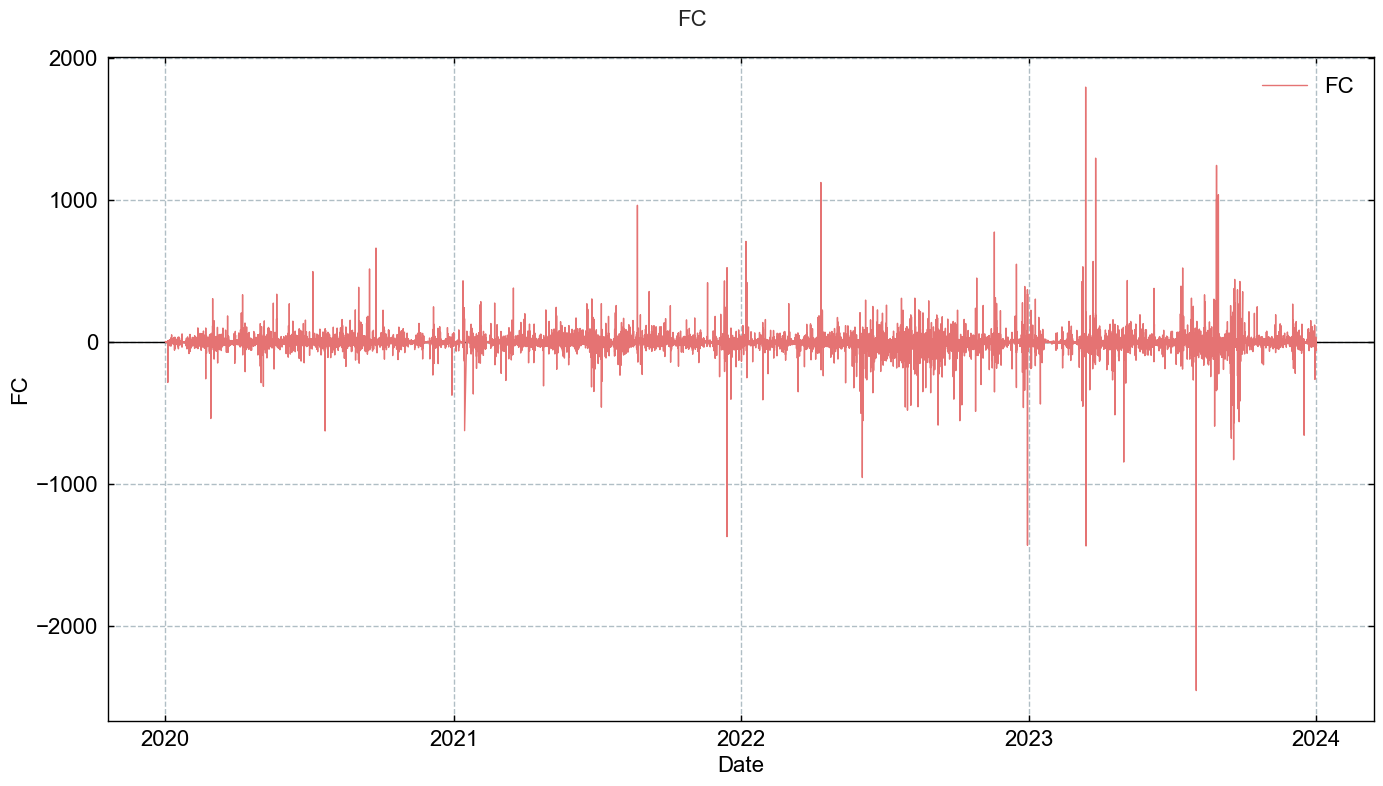

In [96]:
# TimeSeries(series=maindf[FLUXVAR]).plot_interactive()
TimeSeries(series=maindf[FLUXVAR]).plot()

</br>

</br>

# **START FLUX PROCESSING CHAIN**

- First we need to initialize the processing chain by providing some basic info.
- At the same time, some fundamental variables are also created: potential radiation, and two flags based on it: daytime flag (1=daytime) and nighttime flag (1=nighttime).

In [97]:
fpc = FluxProcessingChain(
    maindf=maindf,
    fluxcol=FLUXVAR,
    site_lat=SITE_LAT,
    site_lon=SITE_LON,
    utc_offset=UTC_OFFSET
)

Detected base variable CO2 for FC. (CO2 was used to calculate FC.)
Calculated potential radiation from latitude and longitude (SW_IN_POT) ... 
Calculated daytime flag DAYTIME and nighttime flag NIGHTTIME from SW_IN_POT ...


- Let's check the flux processing chain dataframe: this are the data the chain is working with in this run:

In [98]:
fpc.fpc_df

FC  SW_IN_POT  DAYTIME  NIGHTTIME
TIMESTAMP_MIDDLE                                            
2020-01-01 00:15:00  1.828200        0.0      0.0        1.0
2020-01-01 00:45:00  1.558080        0.0      0.0        1.0
2020-01-01 01:15:00  2.531320        0.0      0.0        1.0
2020-01-01 01:45:00  3.983350        0.0      0.0        1.0
2020-01-01 02:15:00  0.531218        0.0      0.0        1.0
...                       ...        ...      ...        ...
2023-12-31 22:45:00  7.476970        0.0      0.0        1.0
2023-12-31 23:15:00  0.836672        0.0      0.0        1.0
2023-12-31 23:45:00  1.191700        0.0      0.0        1.0
2024-01-01 00:15:00  1.251560        0.0      0.0        1.0
2024-01-01 00:45:00  0.860928        0.0      0.0        1.0

[70130 rows x 4 columns]

</br>

</br>

# **QUALITY FLAG EXTENSION** (Level-2)

> Extract additional quality information from the EddyPro output and store it in newly added quality flags.



Note that the USTAR filtering is not part of the Level-2 calculations.

</br>

## User settings
- A test for missing values is always included: flag calculated here from missing flux values in the EddyPro output file

</br>

### SSITC tests (default: `True`)
- Flag calculated in EddyPro
- Combination of the two partial tests *steady state test* and *developed turbulent conditions test*
- This notebook expects the SSITC flag to follow the flagging policy according to Mauder and Foken 2004:
    - `0` for best quality fluxes
    - `1` for fluxes suitable for general analysis such as annual budgets (although this is debatable)
    - `2` for fluxes that should be discarded from the dataset

In [99]:
TEST_SSITC = True  # Default True

</br>

### Flux base variable completeness test (default: `True`)
- Flag newly calculated here
- Check completeness of the variable that was used to calculate the respective flux
- Example: `CO2` is the base variable that was used to calculate flux `FC`, the test is therefore run on `CO2`
- Checks number of records of the relevant base variable available for each averaging Interval and calculates completeness flag as follows:
    - `0` for files where >= 99% of base variable are available
    - `1` for files where >= 97% and < 99% of base variable are available
    - `2` for files where < 97% of base variable are available
 
List of flux base variables and the corresponding fluxes:
- `CO2`: used to calculate `FC`
- `H2O`: used to calculate `FH2O`
- `H2O`: used to calculate `LE`
- `H2O`: used to calculate `ET`
- `T_SONIC`: used to calculate `H`
- `N2O`: used to calculate `FN2O`
- `CH4`: used to calculate `FCH4`

In [100]:
TEST_GAS_COMPLETENESS = True  # Default True

</br>

### Spectral correction factor test (default: `True`)
- Flag calculated here from the gas `SCF` variable in EddyPro output file

In [101]:
TEST_SPECTRAL_CORRECTION_FACTOR = True  # Default True

</br>

### Signal strength test

<div class="alert alert-block alert-info">
<b>Always recommended if flux was calculated using a gas analyzer.</b>
</div>  

<div class="alert alert-block alert-danger">
<b>Do not use for H (sensible heat flux).</b> This test is only relevant for fluxes where the concentration/temperature was measured by a gas analyzer, e.g. FC, FH2O, LE, ET, N2O, CH4, etc ... 
</div>  

- Signal strength / AGC / window dirtiness test (if available)
- Flag calculated here from the signal strength / AGC variable for the gas analyzer in EddyPro output file
- `SIGNAL_STRENGTH_COL`: Name of the column storing the signal strength, typically 'CUSTOM_AGC_MEAN' for LI-7500, 'CUSTOM_SIGNAL_STRENGTH_IRGA72_MEAN' for LI-7200, or something similar
- `SIGNAL_STRENGTH_THRESHOLD`: Signal strength threshold, flux values where threshold is exceeded are flagged as rejected
- `SIGNAL_STRENGTH_METHOD`: `discard above` flags fluxes where signal strength > threshold, `discard below` where signal strength < threshold

In [102]:
# Signal strength
TEST_SIGNAL_STRENGTH = True
TEST_SIGNAL_STRENGTH_COL = 'CUSTOM_AGC_MEAN'  # Typical variable name in fluxnet files
TEST_SIGNAL_STRENGTH_METHOD = 'discard above'
TEST_SIGNAL_STRENGTH_THRESHOLD = 90

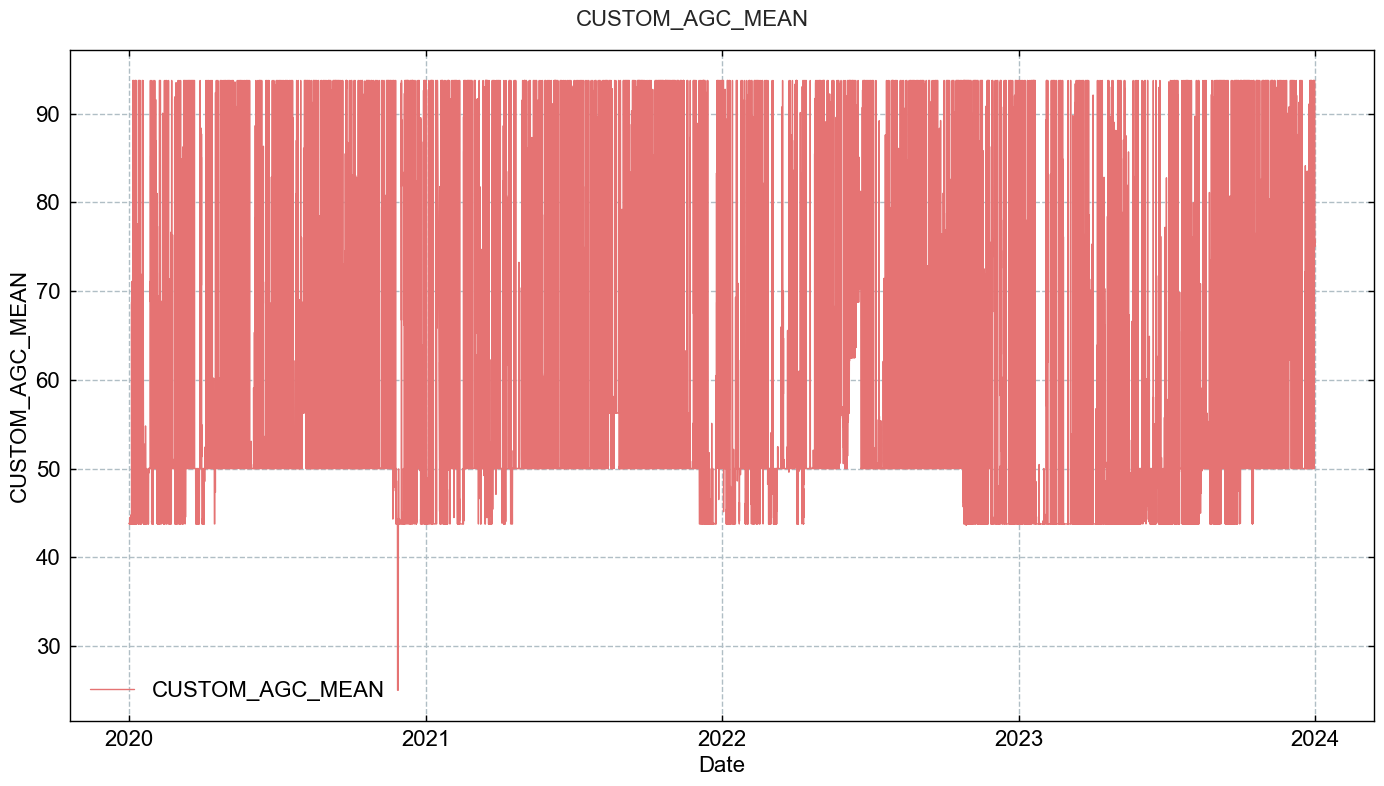

In [103]:
# TimeSeries(series=df_orig[SIGNAL_STRENGTH_COL]).plot_interactive()
TimeSeries(series=maindf[TEST_SIGNAL_STRENGTH_COL]).plot()

</br>

### Raw data screening tests
- Flags were calculated in EddyPro
- See here for more details: [Despiking and raw data statistical screening (EddyPro help)](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html)

In [104]:
TEST_RAWDATA = True  # Default True
TEST_RAWDATA_SPIKES = True  # Default True
TEST_RAWDATA_AMPLITUDE = False  # Default True
TEST_RAWDATA_DROPOUT = True  # Default True
TEST_RAWDATA_ABSLIM = False  # Default False
TEST_RAWDATA_SKEWKURT_HF = False  # Default False
TEST_RAWDATA_SKEWKURT_SF = False  # Default False
TEST_RAWDATA_DISCONT_HF = False  # Default False
TEST_RAWDATA_DISCONT_SF = False  # Default False

</br>

### Angle-of-attack test (default: `False`)
> This test calculates sample-wise Angle of Attacks throughout the current flux averaging period, and flags it if the percentage of angles of attack exceeding a user-defined range is beyond a (user-defined) threshold.  
> Source: [EddyPro help](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html?Highlight=angle%20of%20attack#Angleofattack)  *(3 Jan 2024)*
- Flag was calculated in EddyPro

In [105]:
TEST_RAWDATA_ANGLE_OF_ATTACK = True  # Default False
TEST_RAWDATA_ANGLE_OF_ATTACK_APPLICATION_DATES = [['2008-01-01', '2010-01-01'],
                                                  ['2016-03-01', '2016-05-01']]  # Default False

</br>

### Steadiness of horizontal wind test (default: `False`)
> This test assesses whether the along-wind and crosswind components of the wind vector undergo a systematic reduction (or increase) throughout the file. If the quadratic combination of such systematic variations is beyond the user-selected limit, the flux averaging period is hard-flagged for instationary horizontal wind (Vickers and Mahrt, 1997, Par. 6g).  
> Source: [EddyPro help](https://www.licor.com/env/support/EddyPro/topics/despiking-raw-statistical-screening.html?Highlight=angle%20of%20attack#Steadinessofhorizontalwind)  *(3 Jan 2024)*
- Flag was calculated in EddyPro

In [106]:
TEST_RAWDATA_STEADINESS_OF_HORIZONTAL_WIND = False  # Default False

</br>

</br>

## Run

In [107]:
LEVEL2_SETTINGS = {
    'signal_strength': {
        'apply': TEST_SIGNAL_STRENGTH,
        'signal_strength_col': TEST_SIGNAL_STRENGTH_COL,
        'method': TEST_SIGNAL_STRENGTH_METHOD,
        'threshold': TEST_SIGNAL_STRENGTH_THRESHOLD},
    'raw_data_screening_vm97': {
        'apply': TEST_RAWDATA,
        'spikes': TEST_RAWDATA_SPIKES,
        'amplitude': TEST_RAWDATA_AMPLITUDE,
        'dropout': TEST_RAWDATA_DROPOUT,
        'abslim': TEST_RAWDATA_ABSLIM,
        'skewkurt_hf': TEST_RAWDATA_SKEWKURT_HF,
        'skewkurt_sf': TEST_RAWDATA_SKEWKURT_SF,
        'discont_hf': TEST_RAWDATA_DISCONT_HF,
        'discont_sf': TEST_RAWDATA_DISCONT_SF},
    'ssitc': {
        'apply': TEST_SSITC},
    'gas_completeness': {
        'apply': TEST_GAS_COMPLETENESS},
    'spectral_correction_factor': {
        'apply': TEST_SPECTRAL_CORRECTION_FACTOR},
    'angle_of_attack': {
        'apply': TEST_RAWDATA_ANGLE_OF_ATTACK,
        'application_dates': TEST_RAWDATA_ANGLE_OF_ATTACK_APPLICATION_DATES},
    'steadiness_of_horizontal_wind': {
        'apply': TEST_RAWDATA_STEADINESS_OF_HORIZONTAL_WIND}
}
fpc.level2_quality_flag_expansion(**LEVEL2_SETTINGS)

[MissingValues]  running MissingValues ...
SSITC TEST: Generated new flag variable FLAG_L2_FC_SSITC_TEST, values taken from output variable FC_SSITC_TEST ...
FLUX BASE VARIABLE COMPLETENESS TEST: Generated new flag variable FLAG_L2_FC_COMPLETENESS_TEST, newly calculated from variable CO2, with flag 0 (good values) where available number of records for CO2 >= 0.99, flag 1 (ok values) >= 0.97 and < 0.99, flag 2 (bad values) < 0.97...
SPECTRAL CORRECTION FACTOR TEST: Generating new flag variable FLAG_L2_FC_SCF_TEST, newly calculated from output variable FC_SCF, withflag 0 (good values) where FC_SCF < 2, flag 1 (ok values) where FC_SCF >= 2 and < 4, flag 2 (bad values) where FC_SCF >= 4...
SIGNAL STRENGTH TEST: Generating new flag variable FLAG_L2_FC_SIGNAL_STRENGTH_TEST, newly calculated from output variable CUSTOM_AGC_MEAN, with flag 0 (good values) where CUSTOM_AGC_MEAN <= 90, flag 2 (bad values) where CUSTOM_AGC_MEAN > 90 ...
RAW DATA TEST: Generated new flag variable FLAG_L2_FC_CO2_VM

</br>

</br>

## Finalize Level-2

In [108]:
fpc.finalize_level2(nighttime_threshold=NIGHTTIME_THRESHOLD, daytime_accept_qcf_below=DAYTIME_ACCEPT_QCF_BELOW,
                    nighttimetime_accept_qcf_below=NIGHTTIMETIME_ACCEPT_QCF_BELOW)

++Added new column FLAG_L2_FC_MISSING_TEST.
++Added new column FLAG_L2_FC_SSITC_TEST.
++Added new column FLAG_L2_FC_COMPLETENESS_TEST.
++Added new column FLAG_L2_FC_SCF_TEST.
++Added new column FLAG_L2_FC_SIGNAL_STRENGTH_TEST.
++Added new column FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST.
++Added new column FLAG_L2_FC_CO2_VM97_DROPOUT_TEST.
++Added new column FLAG_L2_FC_VM97_AOA_HF_TEST.
++Added new column SUM_L2_FC_HARDFLAGS.
++Added new column SUM_L2_FC_SOFTFLAGS.
++Added new column SUM_L2_FC_FLAGS.
++Added new column FLAG_L2_FC_QCF.
++Added new column FC_L2_QCF.
++Added new column FC_L2_QCF0.


</br>

### Available `Level-2` variables
- This shows all available Level-2 variables for this flux

In [109]:
[x for x in fpc.fpc_df.columns if 'L2' in x]

['FLAG_L2_FC_MISSING_TEST',
 'FLAG_L2_FC_SSITC_TEST',
 'FLAG_L2_FC_COMPLETENESS_TEST',
 'FLAG_L2_FC_SCF_TEST',
 'FLAG_L2_FC_SIGNAL_STRENGTH_TEST',
 'FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST',
 'FLAG_L2_FC_CO2_VM97_DROPOUT_TEST',
 'FLAG_L2_FC_VM97_AOA_HF_TEST',
 'SUM_L2_FC_HARDFLAGS',
 'SUM_L2_FC_SOFTFLAGS',
 'SUM_L2_FC_FLAGS',
 'FLAG_L2_FC_QCF',
 'FC_L2_QCF',
 'FC_L2_QCF0']

</br>

### Plots

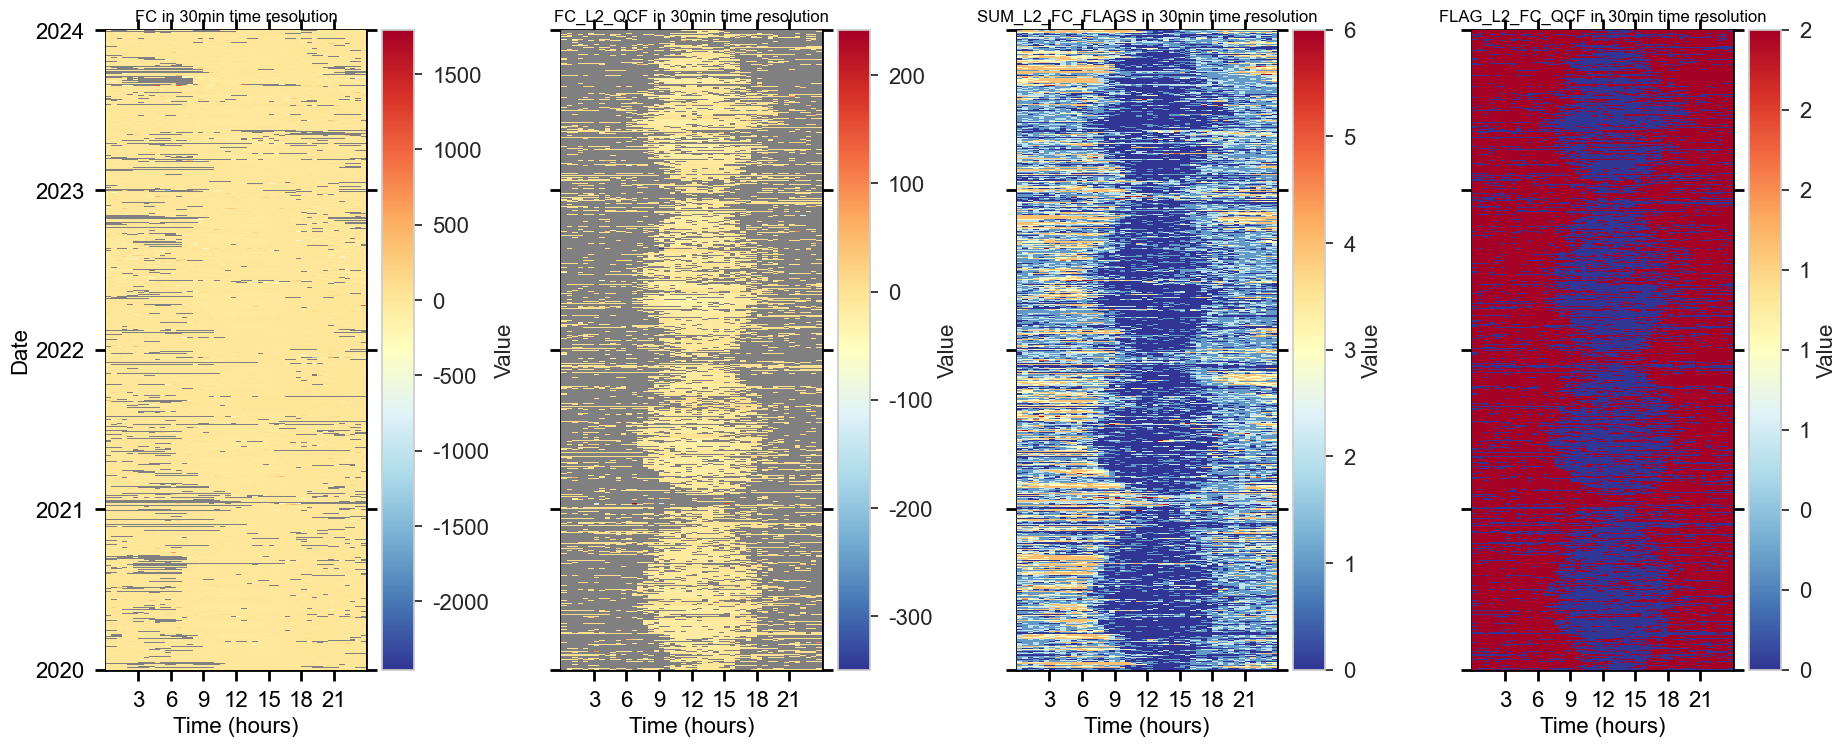

In [110]:
fpc.level2_qcf.showplot_qcf_heatmaps()

In [111]:
# fpc.level2_qcf.showplot_qcf_timeseries()

</br>

### Reports

In [112]:
fpc.level2_qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable FC.

Number of FC records before QC: 63659
+++ FLAG_L2_FC_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 63659 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FC_SSITC_TEST rejected 37722 values (+59.26%)      TOTALS: flag 0: 25937 (40.74%) / flag 1: 0 (0.00%) / flag 2: 37722 (59.26%)
+++ FLAG_L2_FC_COMPLETENESS_TEST rejected 39 values (+0.06%)      TOTALS: flag 0: 25898 (40.68%) / flag 1: 0 (0.00%) / flag 2: 37761 (59.32%)
+++ FLAG_L2_FC_SCF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 25898 (40.68%) / flag 1: 0 (0.00%) / flag 2: 37761 (59.32%)
+++ FLAG_L2_FC_SIGNAL_STRENGTH_TEST rejected 501 values (+0.79%)      TOTALS: flag 0: 25397 (39.90%) / flag 1: 0 (0.00%) / flag 2: 38262 (60.10%)
+++ FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST rejected 102 values (+0.16%)      TOTALS: flag 0: 25295 (39.74%) / flag 1: 0 (0.00%) /

In [113]:
fpc.level2_qcf.report_qcf_series()



SUMMARY: FLAG_L2_FC_QCF, QCF FLAG FOR FC
Between 2020-01-01 00:15 and 2024-01-01 00:45 ...
    Total flux records BEFORE quality checks: 63659 (90.77% of potential)
    Available flux records AFTER quality checks: 25295 (39.74% of total)
    Rejected flux records: 38364 (60.26% of total)
    Potential flux records: 70130
    Potential flux records missed: 6471 (9.23% of potential)



In [114]:
# fpc.level2_qcf.report_qcf_flags()

</br>

</br>

---

# **STORAGE CORRECTION** (Level-3.1)

- The flux storage term (single point) is added to the flux
- For some records, the storage term can be missing. In such cases, missing terms are gap-filled using random forest
- Without gap-filling the storage term, we can lose an additional e.g. 2-3% of flux data

</br>

## Run

In [115]:
fpc.level31_storage_correction(gapfill_storage_term=True)

Detected storage variable SC_SINGLE for FC.
Calculating storage-corrected flux NEE_L3.1 from flux FC and storage term SC_SINGLE ...

Adding new data columns ...
++ Added new columns with timestamp info: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 
++ Added new column .RECORDNUMBER with record numbers from 1 to 70130.

Sanitizing timestamp ...
>>> Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
>>> Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
>>> All rows have timestamp TIMESTAMP_MIDDLE, no rows removed.
>>> Sorting timestamp TIMESTAMP_MIDDLE ascending ...
>>> Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
>>> Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2020-01-01 00:15:00 and 2024-01-01 00:45:00 ...

Training final model ...
>>> Training model <class 'sklearn.ensemble._forest.RandomForestRegre

</br>

## Finalize Level-3.1

In [116]:
fpc.finalize_level31()

++Added new column SC_SINGLE.
++Added new column SC_SINGLE_gfRF_L3.1.
++Added new column FLAG_SC_SINGLE_gfRF_ISFILLED_L3.1.
++Added new column NEE_L3.1.
++Added new column NEE_L3.1_QCF (Level-3.1 with applied quality flag from Level-2).
++Added new column NEE_L3.1_QCF0 (Level-3.1 with applied quality flag from Level-2).


</br>

### Available `Level-3.1` variables
- This shows all available Level-3.1 variables for this flux

In [117]:
[x for x in fpc.fpc_df.columns if 'L3.1' in x]

['SC_SINGLE_gfRF_L3.1',
 'FLAG_SC_SINGLE_gfRF_ISFILLED_L3.1',
 'NEE_L3.1',
 'NEE_L3.1_QCF',
 'NEE_L3.1_QCF0']

</br>

### Plots

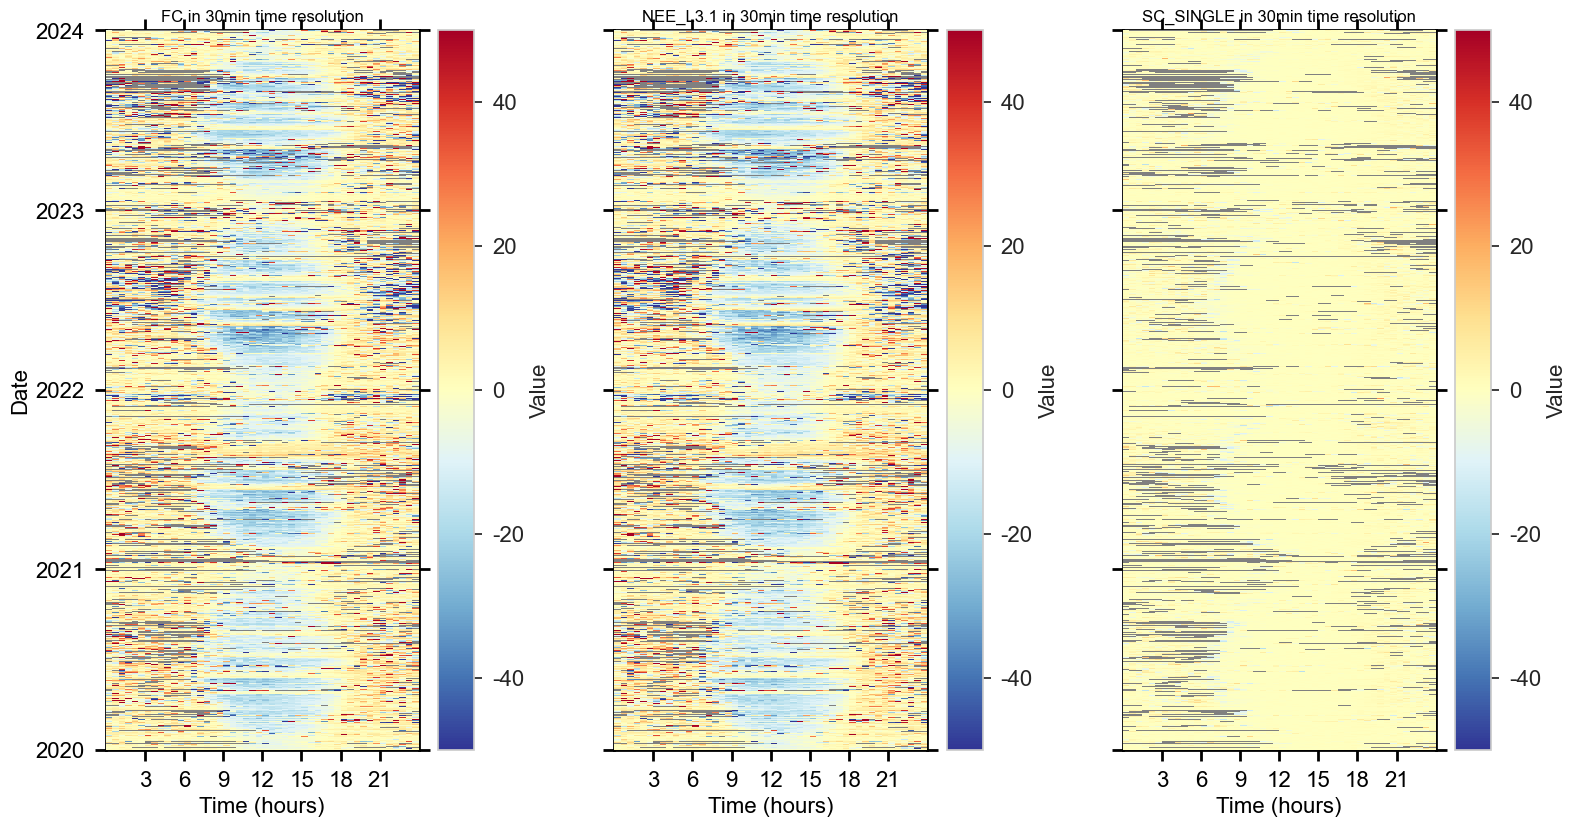

In [118]:
fpc.level31.showplot(maxflux=50)

</br>

### Report

In [119]:
fpc.level31.report()


REPORT: STORAGE CORRECTION FOR FC
Swiss FluxNet processing chain, _L3.1: Storage Correction

The gap-filled storage term SC_SINGLE_gfRF_L3.1 was added to flux FC.
The storage-corrected flux was stored as NEE_L3.1.

The flux was available for 63659 records (FC).
The original, non-gapfilled storage term was available for 61995 records (SC_SINGLE).
This means that the storage term SC_SINGLE is missing for 1664 measured flux (FC) records.
Without gap-filling the storage term SC_SINGLE, 1664 measured flux records (FC) are lost.

For this run, gap-filling of SC_SINGLE was * SELECTED *.
After gap-filling the storage term, it was available for an additional 1664 records (SC_SINGLE_gfRF_L3.1).

In the storage-corrected flux NEE_L3.1 with 63659 records, 
  - 97.4% (61995 records) of used storage terms come from originally calculated data (SC_SINGLE)
  - 2.6% (1664 records) of used storage terms come from gap-filled data (SC_SINGLE_gfRF_L3.1)

Stats for gap-filled storage terms:
                

</br>

---    

# **Analyze highest-quality flux** (so far)
- Analysis of fluxes after Level-3.1 where the overall quality flag `QCF` = 0
- This helps in understanding in what range the "true" flux occurs
- Here, the highest-quality fluxes are additionally filtered for outlier values using the relatively fast Local Outlier Factor test
- For this quick analysis, it is possible that the outlier test cuts off some "real" values that should be retained, but it nevertheless helps in understanding the flux range
- `QCF` = 0 is best quality, `QCF` = medium quality, `QCF` = 2 bad quality and always rejected
- The difference between quality 0 and quality 1 or 2 is huge

>>> Removing outliers from highest-quality DAYTIME fluxes (NEE_L3.1_QCF0)
>>> Outlier removal method: Local outlier factor across all data (n_neighbors=187, contamination=auto, repeat=False)
[LocalOutlierFactorAllData]  running LocalOutlierFactorAllData ...
ITERATION#1: Total found outliers: 294 values (daytime+nighttime)
>>> Largest non-outlier flux >= 0 DAYTIME:   10.6772948
>>> Smallest non-outlier flux >= 0 DAYTIME:  0.002305999999999999
>>> Largest non-outlier flux < 0 DAYTIME:    -0.006777999999999999
>>> Smallest non-outlier flux < 0 DAYTIME:   -35.917979200000005
>>> Removing outliers from highest-quality NIGHTTIME fluxes (NEE_L3.1_QCF0)
>>> Outlier removal method: Local outlier factor across all data (n_neighbors=65, contamination=auto, repeat=False)
[LocalOutlierFactorAllData]  running LocalOutlierFactorAllData ...
ITERATION#1: Total found outliers: 97 values (daytime+nighttime)
>>> Largest non-outlier flux >= 0 NIGHTTIME:   33.096283
>>> Smallest non-outlier flux >= 0 NIGHTT

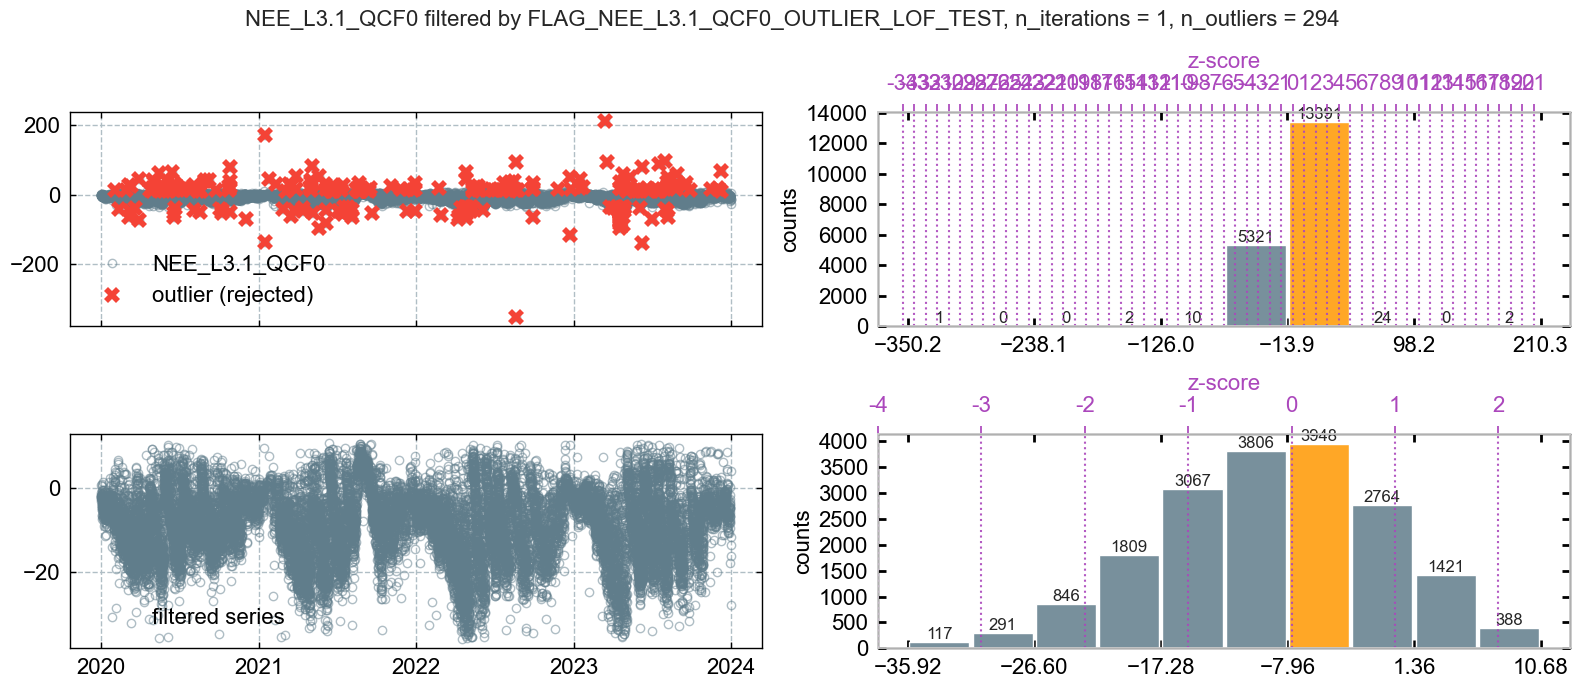

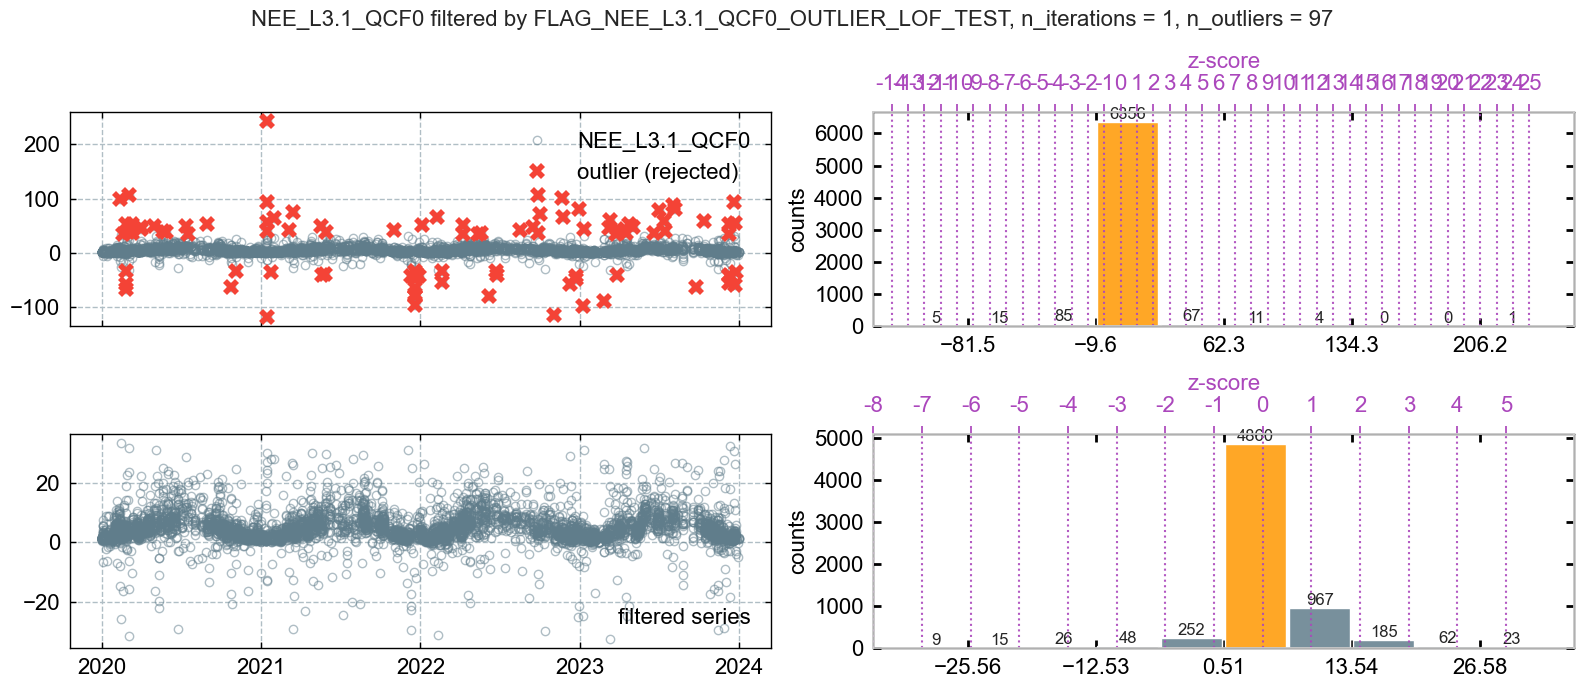

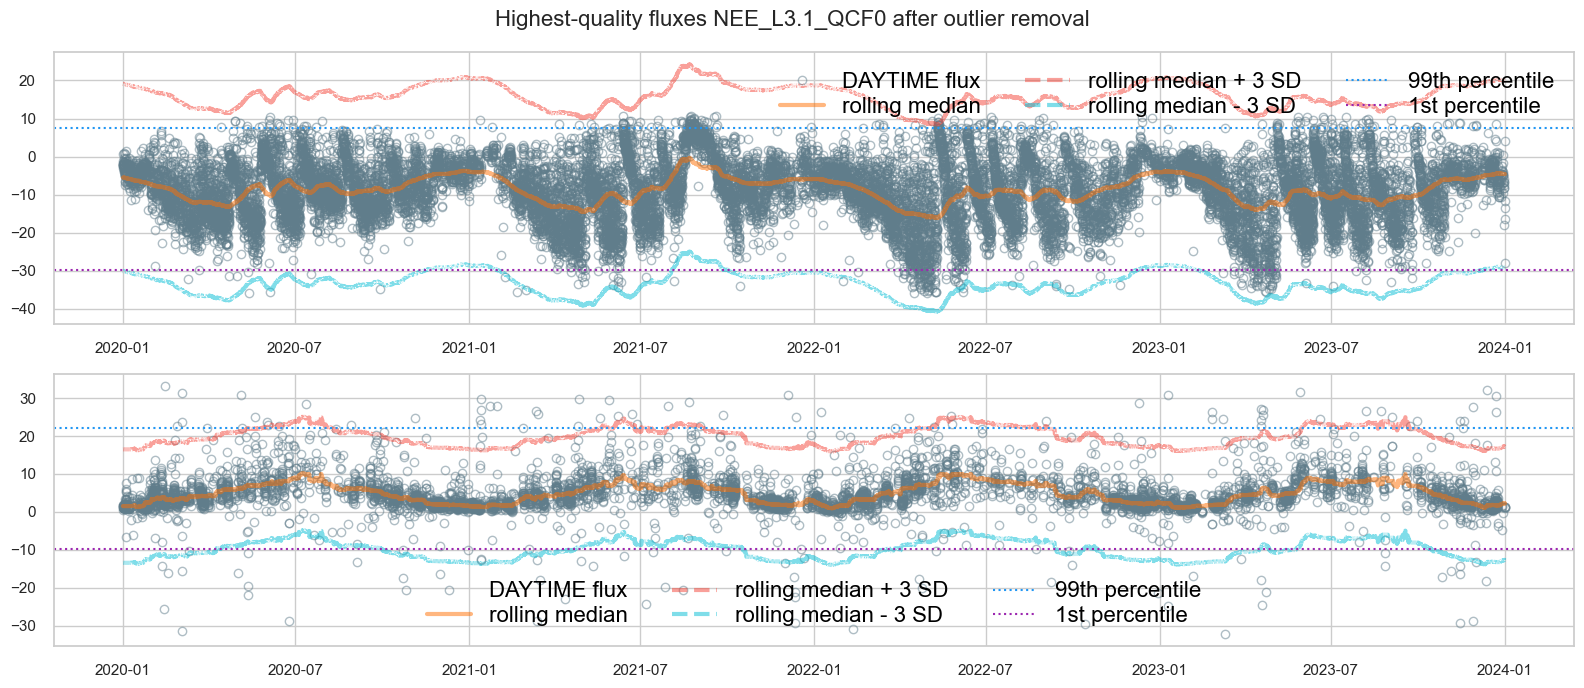

In [120]:
analyze_highest_quality_flux(flux=fpc.fpc_df[fpc.filteredseries_hq.name], nighttime_flag=fpc.fpc_df['NIGHTTIME'])

---

</br>

# **OUTLIER DETECTION** (Level-3.2)
- Running an outlier test creates a *preview* plot of the results
- If the output looks as desired, run `fpc.level32_addflag()` cell below the preview to accept the results you see in the plot
- All subsequent tests will then be based on these results
- This means that each test is run on the data already filtered by the previous test
- Each test creates its own quality flag
- At the end of Level-3.2, an overall quality flag `QCF` is created that combines all of the individual flags into one single flag

</br>

## Plot time series

In [121]:
print(f"{fpc.filteredseries.name} \n(quality-controlled Level-3.1 version of {fpc.fluxcol})")

NEE_L3.1_QCF 
(quality-controlled Level-3.1 version of FC)


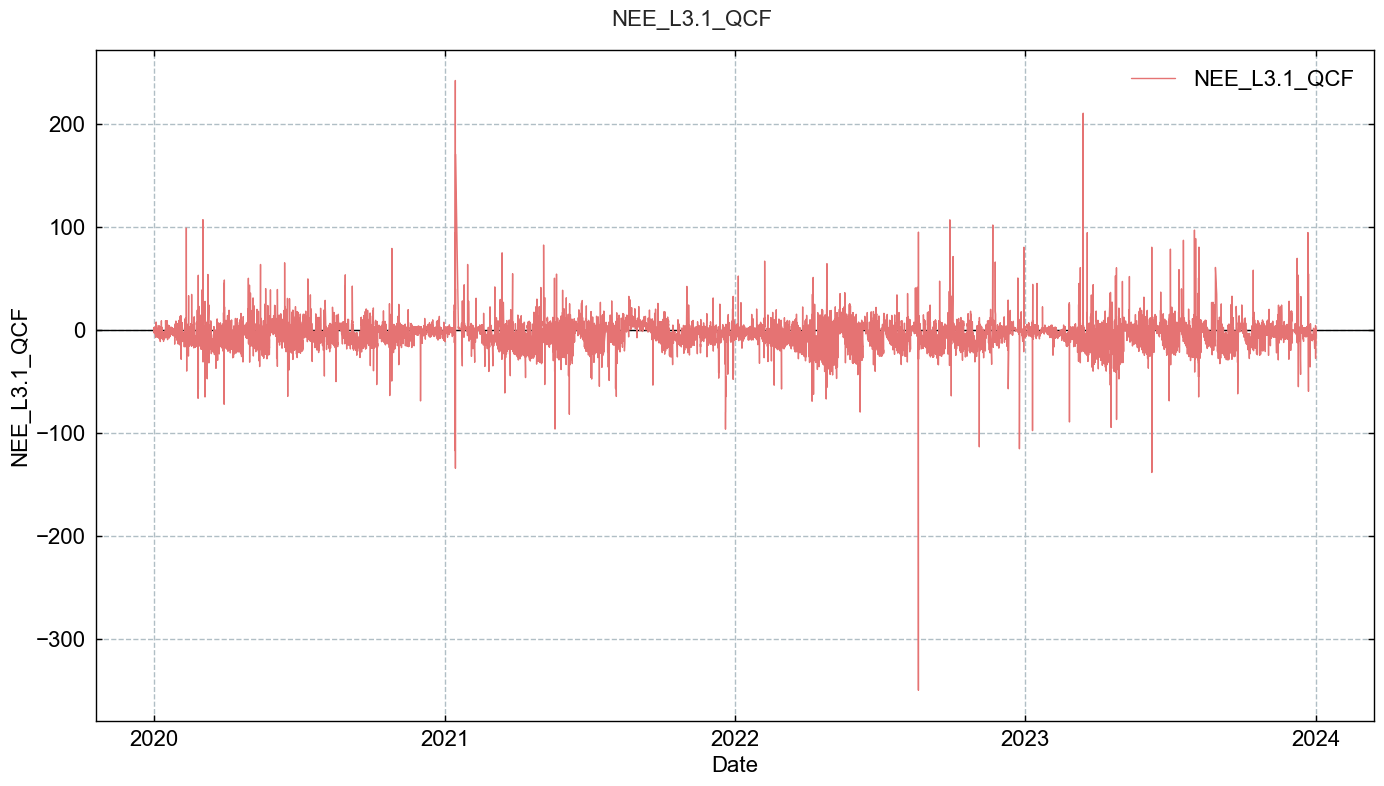

In [122]:
# TimeSeries(series=fpc.fpc_df[fpc.filteredseries.name]).plot_interactive()
TimeSeries(series=fpc.fpc_df[fpc.filteredseries.name]).plot()

</br>

## Initiate calculations

In [123]:
fpc.level32_stepwise_outlier_detection()

</br>

</br>

## Outlier flag: **Absolute limits**

In [124]:
# from diive.pkgs.outlierdetection.absolutelimits import AbsoluteLimits
# help(AbsoluteLimits)

[AbsoluteLimits]  running AbsoluteLimits ...


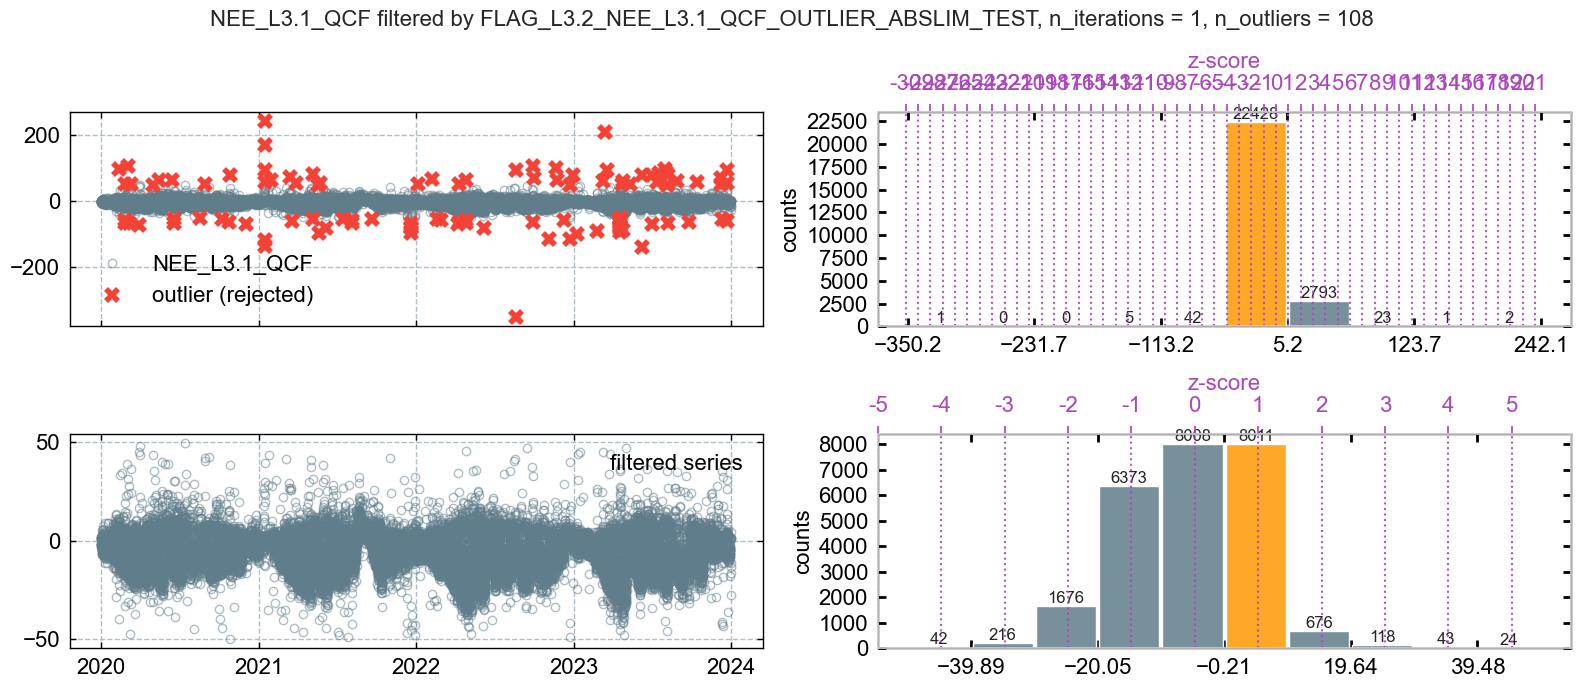

In [125]:
MIN = -50
MAX = 50
fpc.level32_flag_outliers_abslim_test(minval=-50, maxval=50, showplot=True, verbose=True)

In [126]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST to flag data


</br>

</br>

## Outlier flag: **Manual flag**
- The interactive plot can be used to determine the exact start and end of time ranges or data points that need to be removed, e.g. due to known instrument failure

In [127]:
# from diive.pkgs.outlierdetection.manualremoval import ManualRemoval
# help(ManualRemoval)

In [ ]:
# fpc.level32.showplot_cleaned(interactive=True)  # True or False
# fpc.level32.showplot_cleaned(interactive=False)  # True or False

In [ ]:
fpc.level32_flag_manualremoval_test(
    remove_dates=[
        ['2016-03-18 12:15:00', '2016-05-03 06:45:00'],  # Removes date range between two datetimes (inclusive)
        # '2023-12-12 12:45:00'  # Removes data point with specific timestamp
    ],
    showplot=True, verbose=True)

In [ ]:
fpc.level32_addflag()

In [ ]:
# fpc.level32.showplot_cleaned(interactive=True)  # True or False

</br>

</br>

## Outlier flag: **Hampel filter**, separate for daytime and nighttime
- Recommended filter
- Is slow compared to other filters:
    - tested with 1 year of 30MIN time resolution data and it needed approx. 43 seconds on a fast desktop computer

In [128]:
# from diive.pkgs.outlierdetection.hampel import Hampel
# help(Hampel)

[HampelDaytimeNighttime]  running HampelDaytimeNighttime ...
ITERATION#1: Total found outliers: 757 (daytime+nighttime), 266 (daytime), 491 (nighttime)
ITERATION#2: Total found outliers: 57 (daytime+nighttime), 11 (daytime), 46 (nighttime)
ITERATION#3: Total found outliers: 17 (daytime+nighttime), 7 (daytime), 10 (nighttime)
ITERATION#4: Total found outliers: 1 (daytime+nighttime), 1 (daytime), 0 (nighttime)
ITERATION#5: Total found outliers: 0 (daytime+nighttime), 0 (daytime), 0 (nighttime)
CPU times: total: 1min 15s
Wall time: 1min 16s


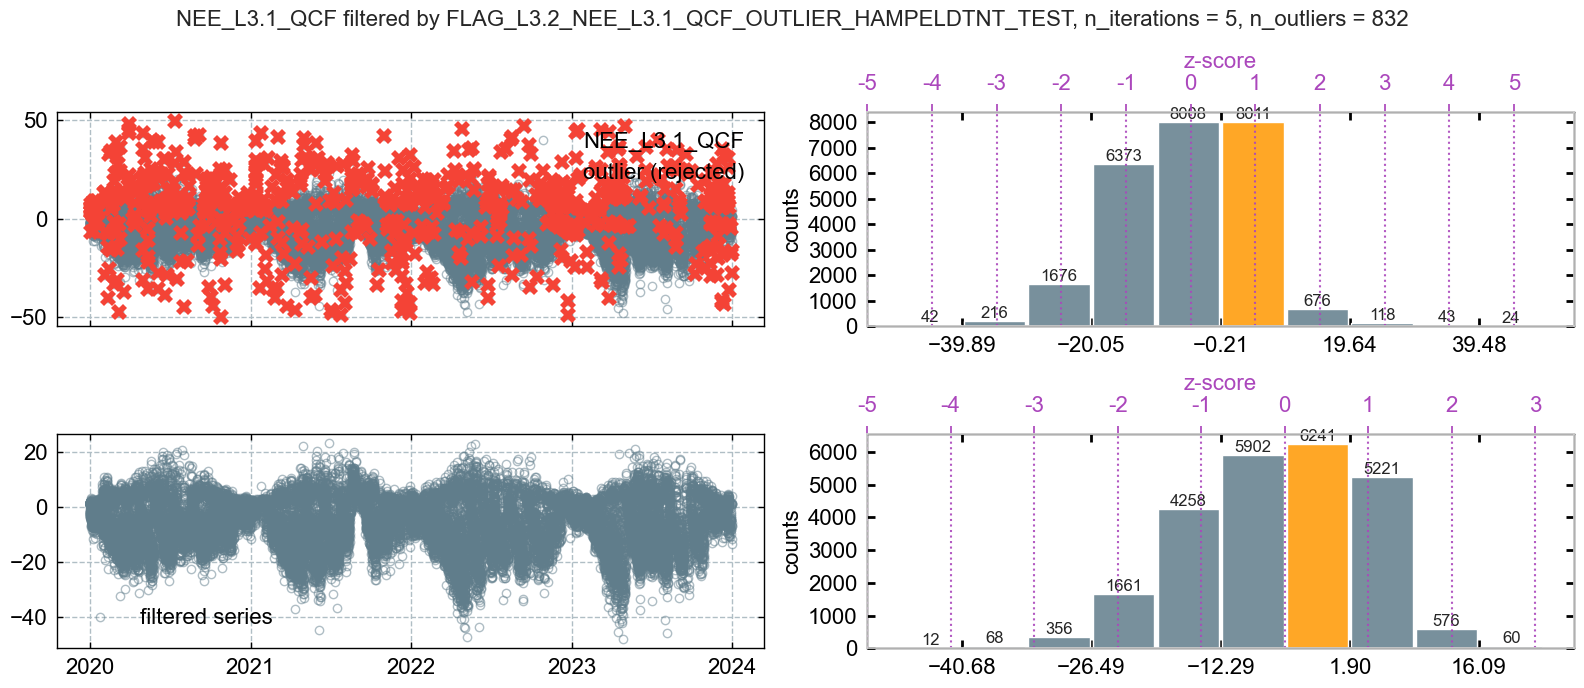

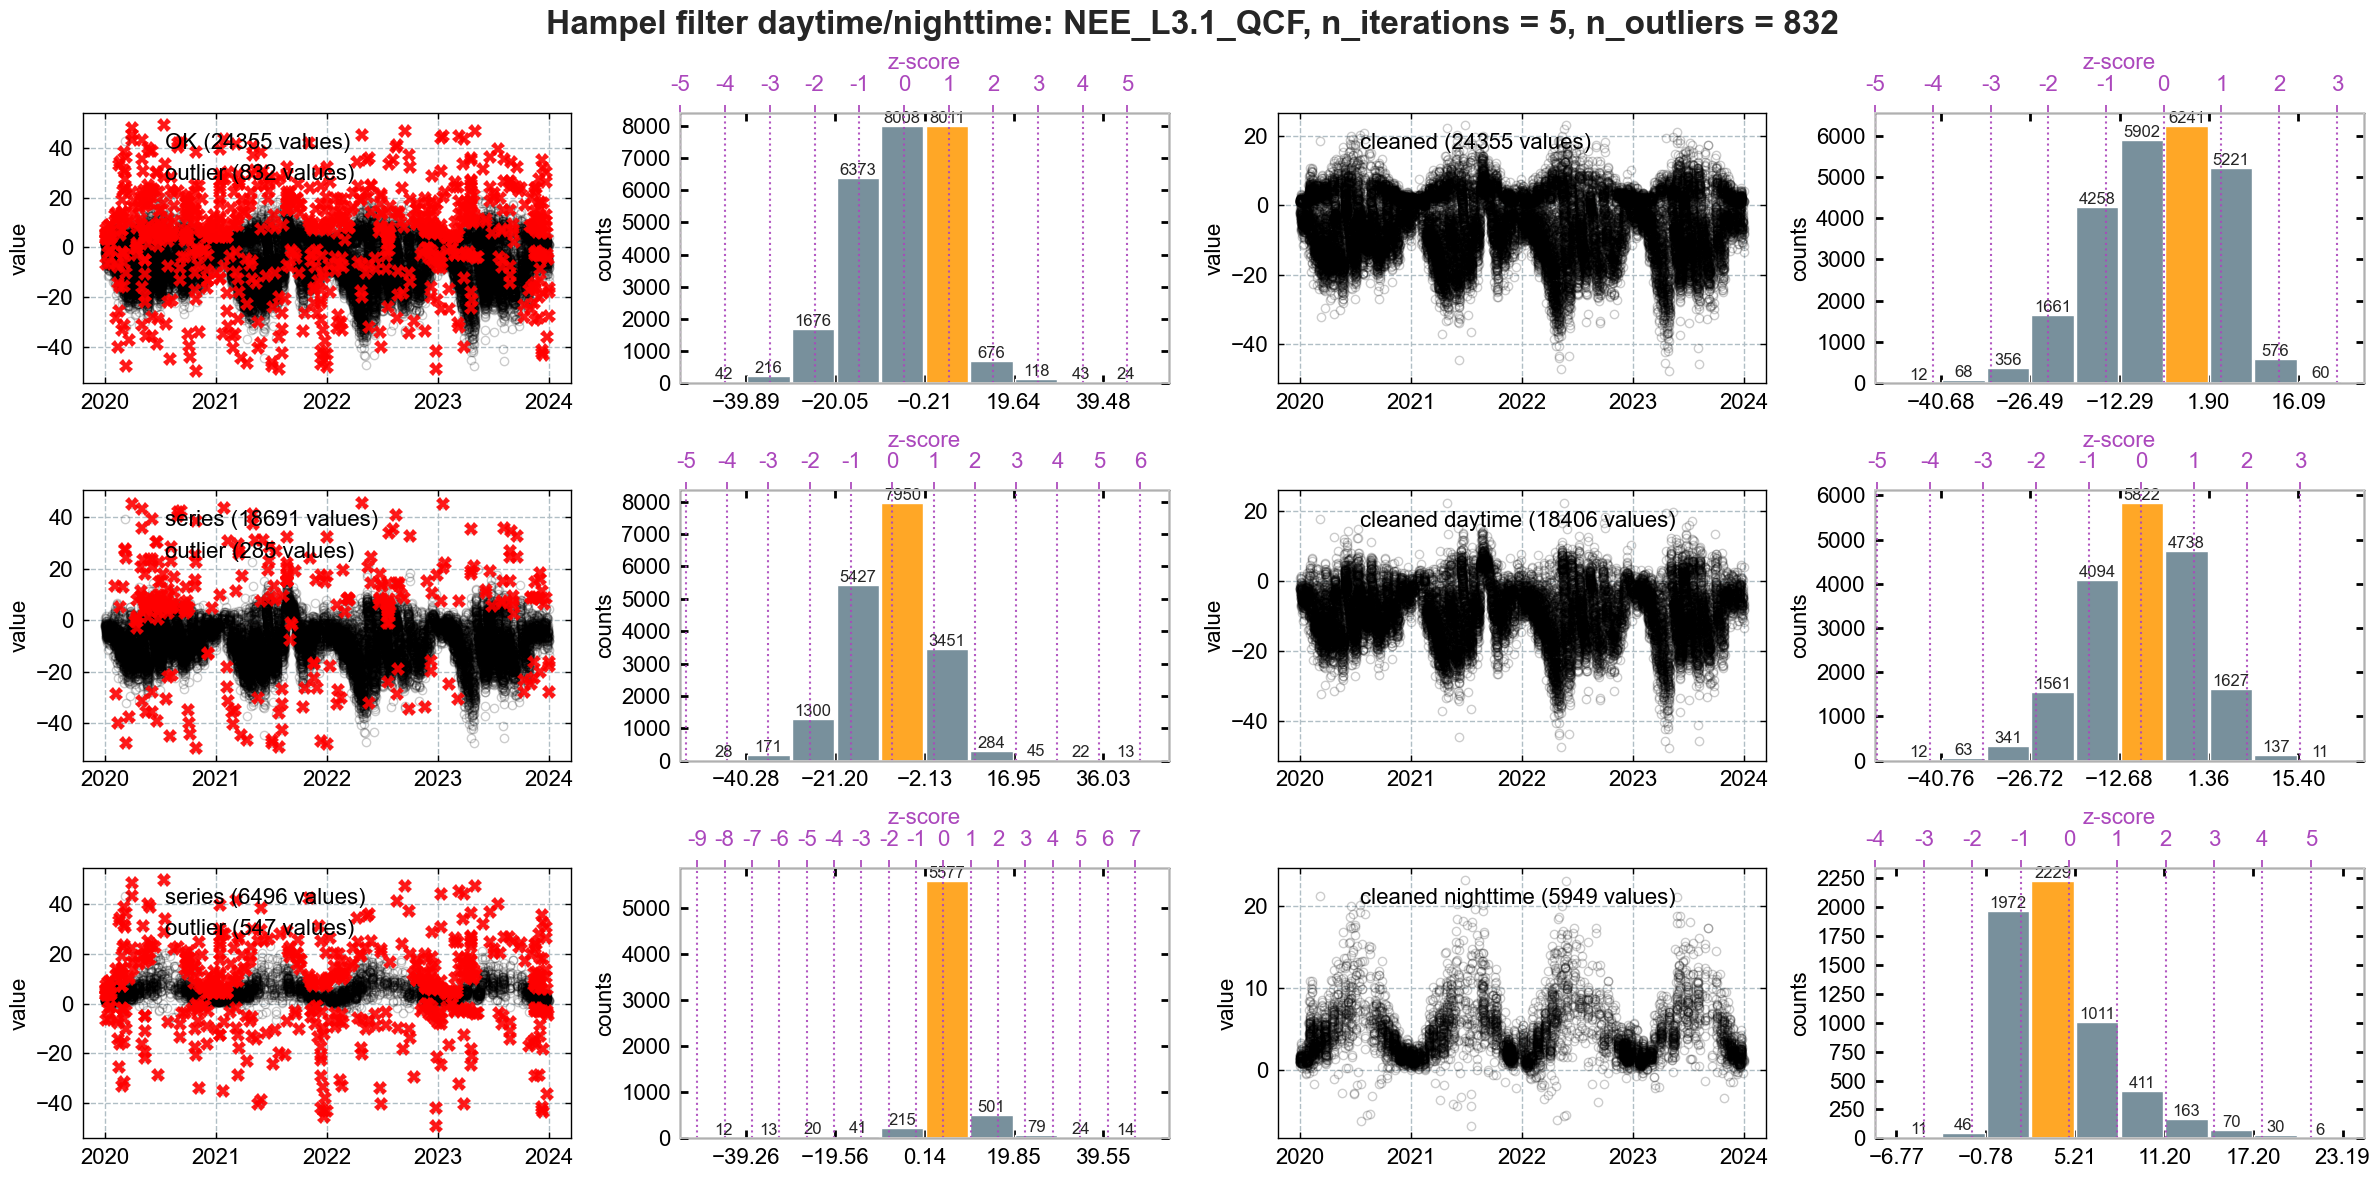

In [129]:
%%time
WINDOW_LENGTH = 48 * 3
N_SIGMA_DT = 3.5
N_SIGMA_NT = 3.5
fpc.level32_flag_outliers_hampel_dtnt_test(window_length=WINDOW_LENGTH, n_sigma_dt=N_SIGMA_DT, n_sigma_nt=N_SIGMA_NT, showplot=True, verbose=True, repeat=True)

In [130]:
fpc.level32_addflag()

++Added flag column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_HAMPELDTNT_TEST to flag data


</br>

</br>

## Outlier flag: **z-score across all data**

In [ ]:
# from diive.pkgs.outlierdetection.zscore import zScore
# help(zScore)

In [ ]:
# THRES_ZSCORE = 6
# fpc.level32_flag_outliers_zscore_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Hampel filter**
- Recommended filter
- Is slow compared to other filters:
    - tested with 1 year of 30MIN time resolution data and it needed approx. 33 seconds on a fast desktop computer
    - tested with 19 years of 30MIN time resolution data and it needed approx. 20 minutes on a fast desktop computer

In [ ]:
# from diive.pkgs.outlierdetection.hampel import Hampel
# help(Hampel)

In [ ]:
# WINDOW_LENGTH = 48 * 13
# N_SIGMA = 6
# %%time
# fpc.level32_flag_outliers_hampel_test(window_length=WINDOW_LENGTH, n_sigma=N_SIGMA, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **z-score over all data**, separate for daytime and nighttime

In [ ]:
# from diive.pkgs.outlierdetection.zscore import zScoreDaytimeNighttime
# help(zScoreDaytimeNighttime)

In [ ]:
# THRES_ZSCORE = 6
# fpc.level32_flag_outliers_zscore_dtnt_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Rolling z-score over all data**

In [ ]:
# from diive.pkgs.outlierdetection.zscore import zScoreRolling
# help(zScoreRolling)

In [ ]:
# THRES_ZSCORE = 5.5
# WINSIZE = 48 * 13
# fpc.level32_flag_outliers_zscore_rolling_test(winsize=WINSIZE, thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local standard deviation**, with rolling median and *rolling* standard deviation

In [ ]:
# from diive.pkgs.outlierdetection.localsd import LocalSD
# help(LocalSD)

In [ ]:
# N_SD = 4.5
# WINSIZE = 48 * 9
# fpc.level32_flag_outliers_localsd_test(n_sd=N_SD, winsize=WINSIZE, constant_sd=False, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local standard deviation**, with rolling median and *constant* standard deviation
- keep standard deviation constant by setting parameter `constant_sd=True`

In [ ]:
# N_SD = 4.5
# WINSIZE = 48 * 9
# fpc.level32_flag_outliers_localsd_test(n_sd=N_SD, winsize=WINSIZE, constant_sd=True, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Increments z-score**

In [ ]:
# from diive.pkgs.outlierdetection.incremental import zScoreIncrements
# help(zScoreIncrements)

In [ ]:
# THRES_ZSCORE = 4
# fpc.level32_flag_outliers_increments_zcore_test(thres_zscore=THRES_ZSCORE, showplot=True, verbose=True, repeat=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local outlier factor**, daytime/nighttime
- Test is run separately for daytime and nighttime data
- Description of local outlier factor: [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)

In [ ]:
# from diive.pkgs.outlierdetection.lof import LocalOutlierFactorDaytimeNighttime
# help(LocalOutlierFactorDaytimeNighttime)

In [ ]:
# N_NEIGHBORS = 100
# CONTAMINATION = None
# fpc.level32_flag_outliers_lof_dtnt_test(n_neighbors=N_NEIGHBORS, contamination=CONTAMINATION, showplot=True, verbose=True, repeat=False, n_jobs=-1)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Local outlier factor**
- Test is run across all data
- Description of local outlier factor: [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)

In [ ]:
# from diive.pkgs.outlierdetection.lof import LocalOutlierFactorAllData
# help(LocalOutlierFactorAllData)

In [ ]:
# N_NEIGHBORS = 24
# CONTAMINATION = None
# fpc.level32_flag_outliers_lof_test(n_neighbors=N_NEIGHBORS, contamination=CONTAMINATION, showplot=True, verbose=True, repeat=False, n_jobs=-1)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Absolute limits**, separate for daytime and nighttime data

In [ ]:
# from diive.pkgs.outlierdetection.absolutelimits import AbsoluteLimitsDaytimeNighttime
# help(AbsoluteLimitsDaytimeNighttime)

In [ ]:
# MIN_DT = -50
# MAX_DT = 50
# MIN_NT = -25
# MAX_NT = 25
# fpc.level32_flag_outliers_abslim_dtnt_test(daytime_minmax=[MIN_DT, MAX_DT], nighttime_minmax=[MIN_NT, MAX_NT], showplot=True, verbose=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## Outlier flag: **Trim nighttime flux data**

In [ ]:
# from diive.pkgs.outlierdetection.trim import TrimLow
# help(TrimLow)

In [ ]:
# fpc.level32_flag_outliers_trim_low_test(trim_nighttime=True, lower_limit=-5, showplot=True, verbose=True)

In [ ]:
# fpc.level32_addflag()

</br>

</br>

## **Finalize Level-3.2**: Calculate overall quality flag (so far)

In [131]:
fpc.finalize_level32(nighttime_threshold=50, daytime_accept_qcf_below=2, nighttimetime_accept_qcf_below=2)

++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST.
++Added new column FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_HAMPELDTNT_TEST.
++Added new column SUM_L3.2_NEE_L3.1_HARDFLAGS.
++Added new column SUM_L3.2_NEE_L3.1_SOFTFLAGS.
++Added new column SUM_L3.2_NEE_L3.1_FLAGS.
++Added new column FLAG_L3.2_NEE_L3.1_QCF.
++Added new column NEE_L3.1_L3.2_QCF.
++Added new column NEE_L3.1_L3.2_QCF0.


</br>

### Available `Level-3.2` variables
- This shows all available Level-3.2 variables for this flux

In [132]:
[x for x in fpc.fpc_df.columns if 'L3.2' in x]

['FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST',
 'FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_HAMPELDTNT_TEST',
 'SUM_L3.2_NEE_L3.1_HARDFLAGS',
 'SUM_L3.2_NEE_L3.1_SOFTFLAGS',
 'SUM_L3.2_NEE_L3.1_FLAGS',
 'FLAG_L3.2_NEE_L3.1_QCF',
 'NEE_L3.1_L3.2_QCF',
 'NEE_L3.1_L3.2_QCF0']

</br>

### Plot filtered flux after Level-3.2
In the four panels, from left to right:
- flux after Level-3.1, before outlier removal
- flux after Level-3.2, after outlier removal
- sum of the individual test flags
- overall flag `QCF` (quality control flag), where `0`=best quality, `1`=medium quality, `2`=bad quality  

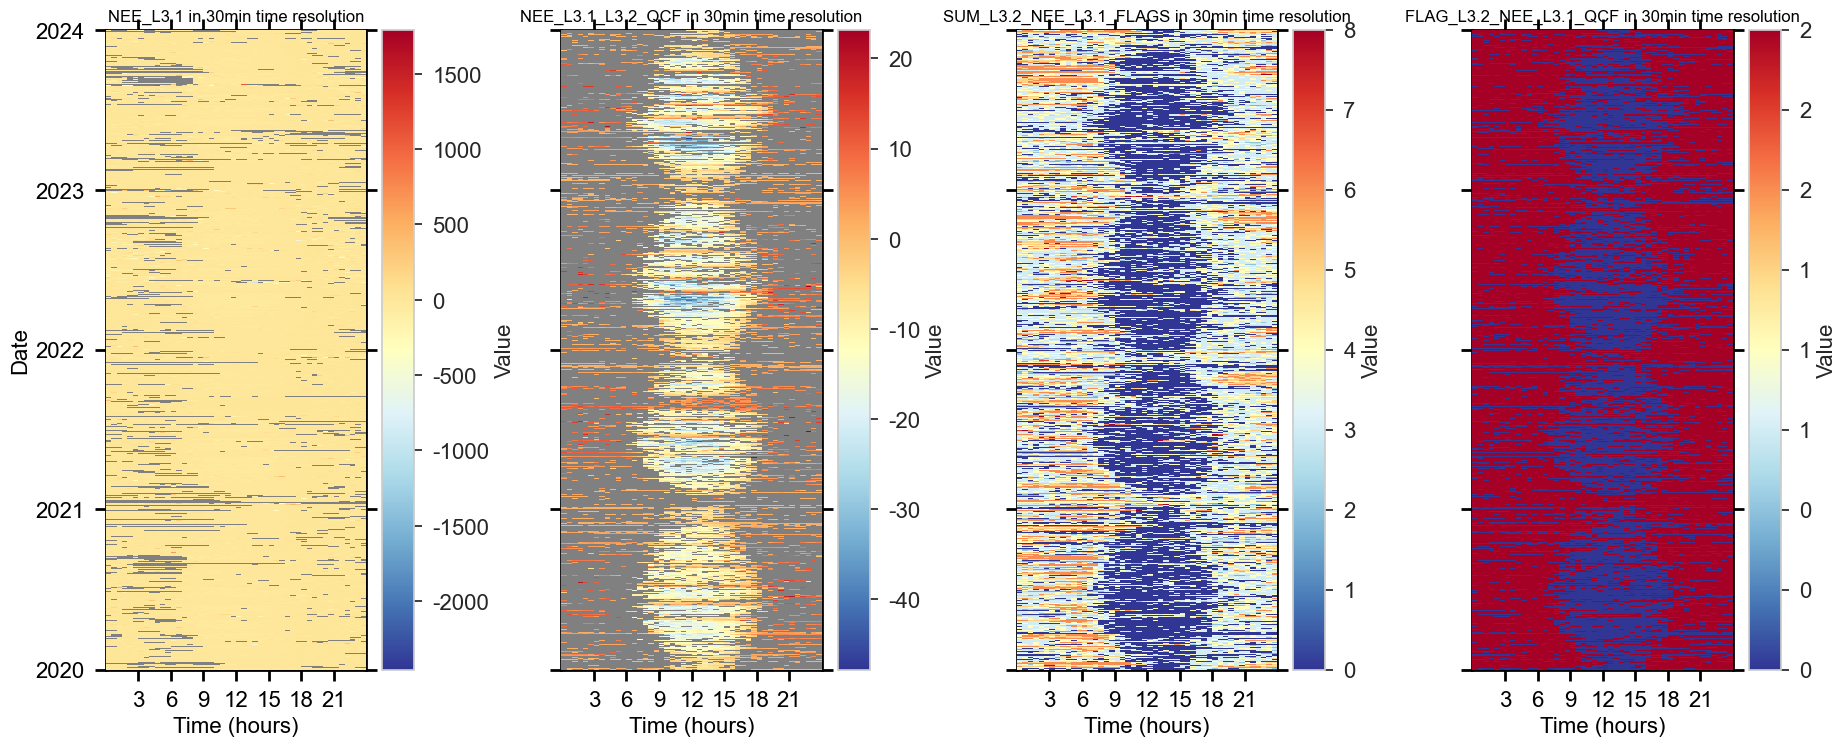

In [133]:
fpc.level32_qcf.showplot_qcf_heatmaps()

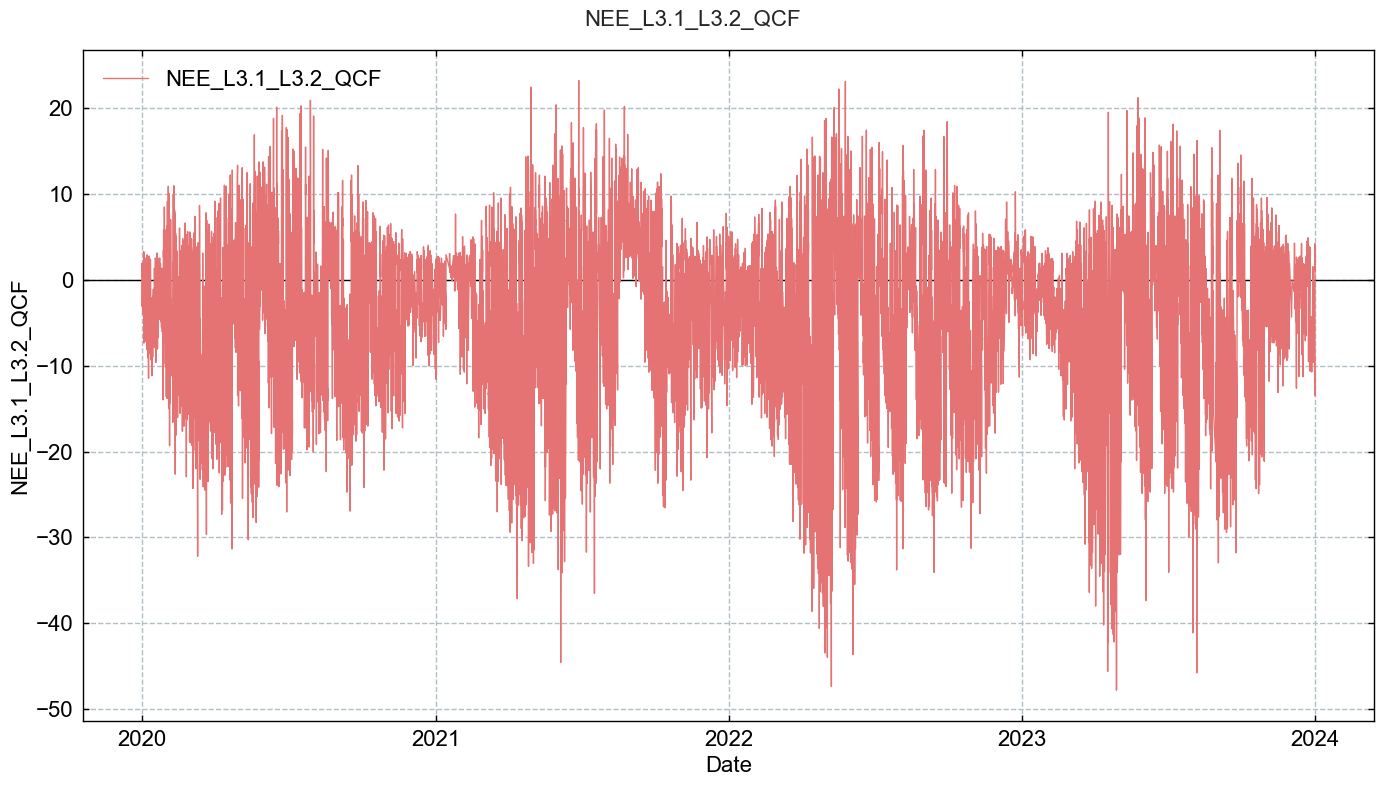

In [134]:
TimeSeries(series=fpc.filteredseries).plot()
# TimeSeries(series=fpc.filteredseries).plot_interactive()

In [ ]:
# fpc.level32_qcf.showplot_qcf_timeseries()

</br>

### Reports

In [135]:
fpc.level32_qcf.report_qcf_evolution()



QCF FLAG EVOLUTION
This output shows the evolution of the QCF overall quality flag
when test flags are applied sequentially to the variable NEE_L3.1.

Number of NEE_L3.1 records before QC: 63659
+++ FLAG_L2_FC_MISSING_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 63659 (100.00%) / flag 1: 0 (0.00%) / flag 2: 0 (0.00%)
+++ FLAG_L2_FC_SSITC_TEST rejected 12019 values (+18.88%)      TOTALS: flag 0: 25937 (40.74%) / flag 1: 25703 (40.38%) / flag 2: 12019 (18.88%)
+++ FLAG_L2_FC_COMPLETENESS_TEST rejected 43 values (+0.07%)      TOTALS: flag 0: 25898 (40.68%) / flag 1: 25699 (40.37%) / flag 2: 12062 (18.95%)
+++ FLAG_L2_FC_SCF_TEST rejected 0 values (+0.00%)      TOTALS: flag 0: 25898 (40.68%) / flag 1: 25699 (40.37%) / flag 2: 12062 (18.95%)
+++ FLAG_L2_FC_SIGNAL_STRENGTH_TEST rejected 4273 values (+6.71%)      TOTALS: flag 0: 25397 (39.90%) / flag 1: 21927 (34.44%) / flag 2: 16335 (25.66%)
+++ FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST rejected 174 values (+0.27%)      TOTALS: flag 0: 252

In [136]:
fpc.level32_qcf.report_qcf_series()



SUMMARY: FLAG_L3.2_NEE_L3.1_QCF, QCF FLAG FOR NEE_L3.1
Between 2020-01-01 00:15 and 2024-01-01 00:45 ...
    Total flux records BEFORE quality checks: 63659 (90.77% of potential)
    Available flux records AFTER quality checks: 24355 (38.26% of total)
    Rejected flux records: 39304 (61.74% of total)
    Potential flux records: 70130
    Potential flux records missed: 6471 (9.23% of potential)



In [137]:
fpc.level32_qcf.report_qcf_flags()


REPORT: FLAGS INCL. MISSING VALUES
Stats with missing values in the dataset
FLAG_L2_FC_MISSING_TEST:
    OVERALL flag 0.0: 63659 values (90.77%)  
    OVERALL flag 2.0: 6471 values (9.23%)  
    OVERALL flag missing: 0 values (0.00%)  

    DAYTIME flag 0.0: 31866 values (94.50%)  
    DAYTIME flag 2.0: 1854 values (5.50%)  
    DAYTIME flag missing: 0 values (0.00%)  

    NIGHTTIME flag 0.0: 31793 values (87.32%)  
    NIGHTTIME flag 2.0: 4617 values (12.68%)  
    NIGHTTIME flag missing: 0 values (0.00%)  

FLAG_L2_FC_SSITC_TEST:
    OVERALL flag 0.0: 25937 values (36.98%)  
    OVERALL flag 1.0: 25703 values (36.65%)  
    OVERALL flag 2.0: 12019 values (17.14%)  
    OVERALL flag missing: 6471 values (9.23%)  

    DAYTIME flag 0.0: 19029 values (56.43%)  
    DAYTIME flag 1.0: 8881 values (26.34%)  
    DAYTIME flag 2.0: 3956 values (11.73%)  
    DAYTIME flag missing: 1854 values (5.50%)  

    NIGHTTIME flag 0.0: 6908 values (18.97%)  
    NIGHTTIME flag 1.0: 16822 values (46.

</br>

</br>

# Add results to main data

In [138]:
print(f"Currently the main dataframe has {len(maindf.columns)} variables.")
print(f"The flux processing chain dataframe with new results has {len(fpc.fpc_df.columns)} variables for flux {FLUXVAR}.")

Currently the main dataframe has 320 variables.
The flux processing chain dataframe with new results has 32 variables for flux FC.


In [139]:
maindf2 = maindf.copy()  # Make a copy so we can restart this step directly from here, in case something goes wrong further down, better safe than sorry
print(f"Preparing to add new results to main data, checking for new variables:")
newcols = [c for c in fpc.fpc_df.columns if c not in maindf2.columns]
print(f"In total, {len(newcols)} new variables will be added back to the main data.")
[print(f"--> Found new variable {col} in new results.") for col in newcols];

Preparing to add new results to main data, checking for new variables:
In total, 29 new variables will be added back to the main data.
--> Found new variable DAYTIME in new results.
--> Found new variable NIGHTTIME in new results.
--> Found new variable FLAG_L2_FC_MISSING_TEST in new results.
--> Found new variable FLAG_L2_FC_SSITC_TEST in new results.
--> Found new variable FLAG_L2_FC_COMPLETENESS_TEST in new results.
--> Found new variable FLAG_L2_FC_SCF_TEST in new results.
--> Found new variable FLAG_L2_FC_SIGNAL_STRENGTH_TEST in new results.
--> Found new variable FLAG_L2_FC_CO2_VM97_SPIKE_HF_TEST in new results.
--> Found new variable FLAG_L2_FC_CO2_VM97_DROPOUT_TEST in new results.
--> Found new variable FLAG_L2_FC_VM97_AOA_HF_TEST in new results.
--> Found new variable SUM_L2_FC_HARDFLAGS in new results.
--> Found new variable SUM_L2_FC_SOFTFLAGS in new results.
--> Found new variable SUM_L2_FC_FLAGS in new results.
--> Found new variable FLAG_L2_FC_QCF in new results.
--> Foun

In [140]:
maindf2 = pd.concat([maindf2, fpc.fpc_df[newcols]], axis=1)
print(f"New variables were added to main data.")
print(f"The main dataframe now has {len(maindf2.columns)} variables.")

New variables were added to main data.
The main dataframe now has 349 variables.


</br>

</br>

# Overview after `Level-3.2`

</br>

## Flux variable names

In [141]:
fluxes_qcf = [c for c in maindf2.columns if str(c).endswith("_QCF") and not str(c).startswith("FLAG_") and "L3.2" in c]
fluxes_qcf0 = [c for c in maindf2.columns if
               str(c).endswith("_QCF0") and not str(c).startswith("FLAG_") and "L3.2" in c]
print(f"Quality-controlled fluxes: {fluxes_qcf}")
print(f"Quality-controlled fluxes, HIGHEST QUALITY: {fluxes_qcf0}")
if (DAYTIME_ACCEPT_QCF_BELOW == 1) & (NIGHTTIMETIME_ACCEPT_QCF_BELOW == 1):
    print(f"{'*' * 100}\nNote that since only QCF below 1 is accepted for daytime and nighttime data, "
          f"the _QCF and _QCF0 variables are identical.")

Quality-controlled fluxes: ['NEE_L3.1_L3.2_QCF']
Quality-controlled fluxes, HIGHEST QUALITY: ['NEE_L3.1_L3.2_QCF0']
****************************************************************************************************
Note that since only QCF below 1 is accepted for daytime and nighttime data, the _QCF and _QCF0 variables are identical.


</br>

In [142]:
FLUXVAR2QCF = fpc.filteredseries_level2_qcf.name
FLUXVAR31QCF = fpc.filteredseries_level31_qcf.name
FLUXVAR32QCF = fpc.filteredseries_level32_qcf.name
FLUXVAR32QCF_HQ = f"{FLUXVAR32QCF}0"

print("--------------------------")
print("OVERVIEW OF FLUX VARIABLES")
print("--------------------------")
print("")
print("Input flux variable:")
print(f"{FLUXVAR}")
print("")
print("Intermediate flux variables:")
print(f"  - {FLUXVAR2QCF} (quality-controlled with Level-2 flags)  -->  not used in any further processing steps")
print(
    f"  - {FLUXVAR31QCF} (quality-controlled with Level-2 flags, including Level-3.1 storage correction)  -->  not used in any further processing steps")
print("")
print("Important flux variables:")
print(
    f"  - {FLUXVAR32QCF_HQ} (HIGHEST QUALITY ONLY (QCF=0), quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)  -->  USED FOR USTAR DETECTION")
print(
    f"  - {FLUXVAR32QCF} (quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)  -->  CAN BE USED FOR BUDGETS (after USTAR application and gap-filling)")
if (DAYTIME_ACCEPT_QCF_BELOW == 1) & (NIGHTTIMETIME_ACCEPT_QCF_BELOW == 1):
    print(f"{'*' * 100}\nNote that since only QCF below 1 is accepted for daytime and nighttime data, "
          f"the _QCF and _QCF0 variables are identical.")

--------------------------
OVERVIEW OF FLUX VARIABLES
--------------------------

Input flux variable:
FC

Intermediate flux variables:
  - FC_L2_QCF (quality-controlled with Level-2 flags)  -->  not used in any further processing steps
  - NEE_L3.1_QCF (quality-controlled with Level-2 flags, including Level-3.1 storage correction)  -->  not used in any further processing steps

Important flux variables:
  - NEE_L3.1_L3.2_QCF0 (HIGHEST QUALITY ONLY (QCF=0), quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)  -->  USED FOR USTAR DETECTION
  - NEE_L3.1_L3.2_QCF (quality-controlled with Level-2 and Level-3.2 flags, including Level-3.1 storage correction)  -->  CAN BE USED FOR BUDGETS (after USTAR application and gap-filling)
****************************************************************************************************
Note that since only QCF below 1 is accepted for daytime and nighttime data, the _QCF and _QCF0 variables are identical.


</br>

</br>

## Plot quality-controlled flux after `Level-3.2`
- Plot flux after storage-correction, flux quality control and outlier removal

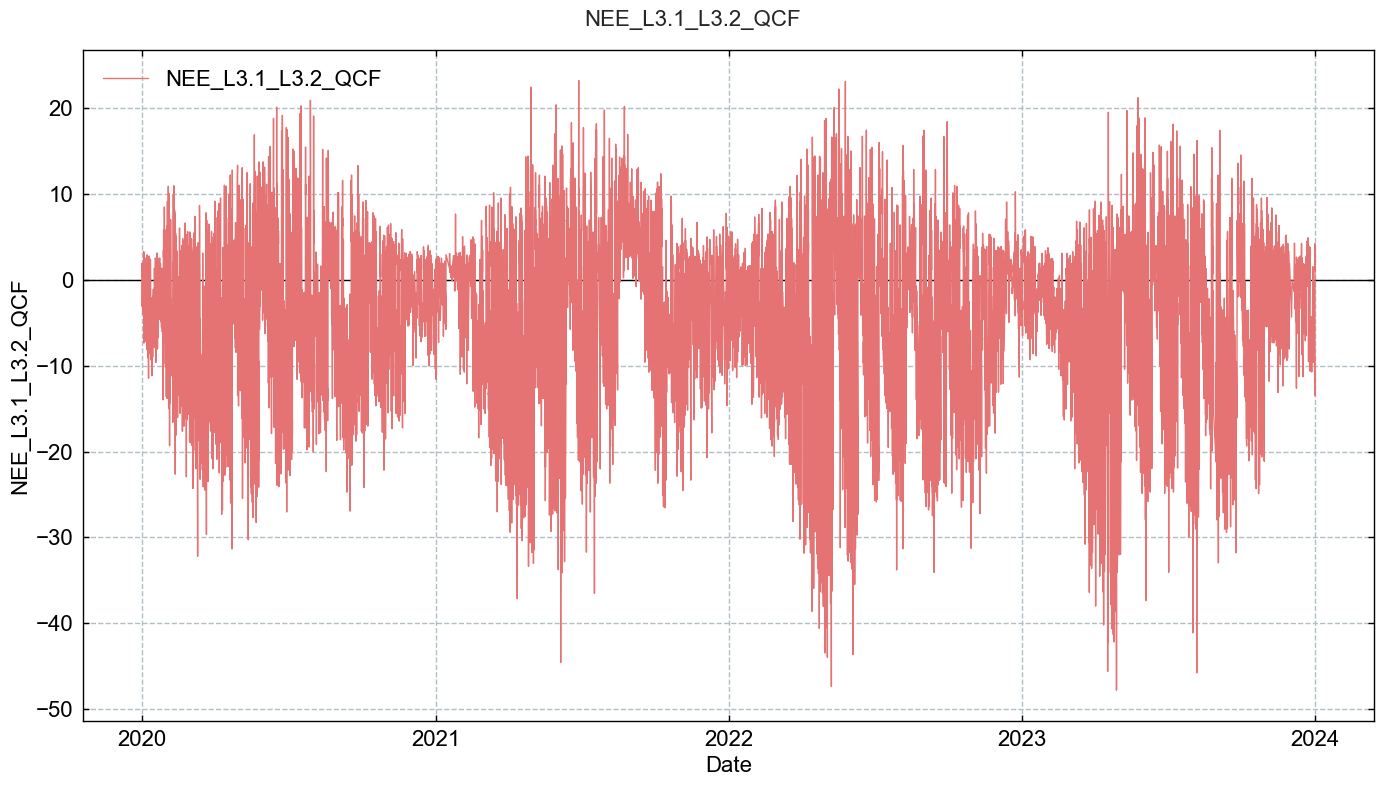

In [143]:
# TimeSeries(series=fpc.fpc_df[fluxhq]).plot_interactive()
TimeSeries(series=fpc.fpc_df[FLUXVAR32QCF]).plot()

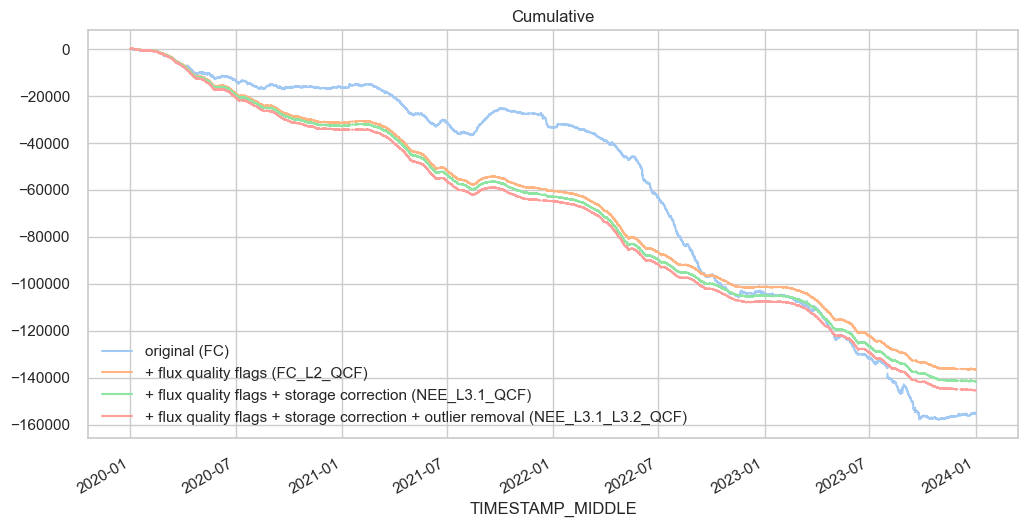

In [144]:
# Creating a dictionary by passing Series objects as values

frame = {
    f'original ({FLUXVAR})': fpc.fpc_df[FLUXVAR],
    f'+ flux quality flags ({FLUXVAR2QCF})': fpc.fpc_df[FLUXVAR2QCF],
    f'+ flux quality flags + storage correction ({FLUXVAR31QCF})': fpc.fpc_df[FLUXVAR31QCF],
    f'+ flux quality flags + storage correction + outlier removal ({FLUXVAR32QCF})': fpc.fpc_df[FLUXVAR32QCF]
}

overview = pd.DataFrame(frame)
overview.cumsum().plot(title=f"Cumulative", figsize=(12, 6), x_compat=True);

</br>

## Comparison flux quality

In [145]:
[print(c) for c in maindf2.columns if "QCF" in c];

FLAG_L2_FC_QCF
FC_L2_QCF
FC_L2_QCF0
NEE_L3.1_QCF
NEE_L3.1_QCF0
FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_ABSLIM_TEST
FLAG_L3.2_NEE_L3.1_QCF_OUTLIER_HAMPELDTNT_TEST
FLAG_L3.2_NEE_L3.1_QCF
NEE_L3.1_L3.2_QCF
NEE_L3.1_L3.2_QCF0


In [146]:
import scipy.stats

MQ = fpc.level32_qcf.flagqcf == 1

highest_quality = maindf2[FLUXVAR32QCF_HQ].copy().dropna()
medium_quality = maindf2[FLUXVAR32QCF][MQ].copy().dropna()
medium_quality.name = f"{medium_quality.name}1"
print(scipy.stats.ttest_ind(a=highest_quality.to_numpy(), b=medium_quality.to_numpy(), equal_var=True))

TtestResult(statistic=np.float64(nan), pvalue=np.float64(nan), df=np.float64(nan))


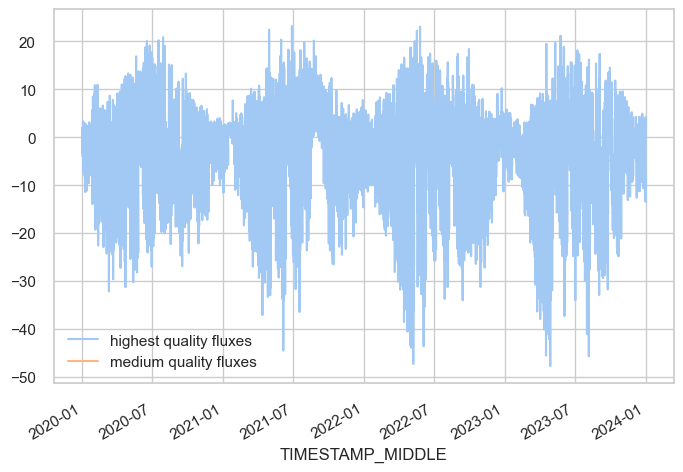

In [147]:
ab = {'highest quality fluxes': highest_quality, 'medium quality fluxes': medium_quality}
pd.DataFrame.from_dict(ab).plot(x_compat=True);

In [148]:
pd.concat([highest_quality.describe(), medium_quality.describe()], axis=1)

NEE_L3.1_L3.2_QCF0  NEE_L3.1_L3.2_QCF1
count        24355.000000                 0.0
mean            -5.972919                 NaN
std              9.383561                 NaN
min            -47.777410                 NaN
25%            -12.654601                 NaN
50%             -5.296665                 NaN
75%              1.775055                 NaN
max             23.190664                 NaN

</br>

## Available `Level-3.2` fluxes

In [149]:
_fluxcols = [x for x in fpc.fpc_df.columns if
             'L3.1' and 'L3.2' in x and str(x).endswith('_QCF') and not str(x).startswith('FLAG_')]
_fluxcols

['NEE_L3.1_L3.2_QCF']

In [150]:
_subset = fpc.fpc_df[_fluxcols]
_subset

NEE_L3.1_L3.2_QCF
TIMESTAMP_MIDDLE                      
2020-01-01 00:15:00                NaN
2020-01-01 00:45:00           1.492641
2020-01-01 01:15:00                NaN
2020-01-01 01:45:00                NaN
2020-01-01 02:15:00           0.483683
...                                ...
2023-12-31 22:45:00                NaN
2023-12-31 23:15:00           1.190371
2023-12-31 23:45:00           1.334124
2024-01-01 00:15:00           1.414890
2024-01-01 00:45:00           1.024868

[70130 rows x 1 columns]

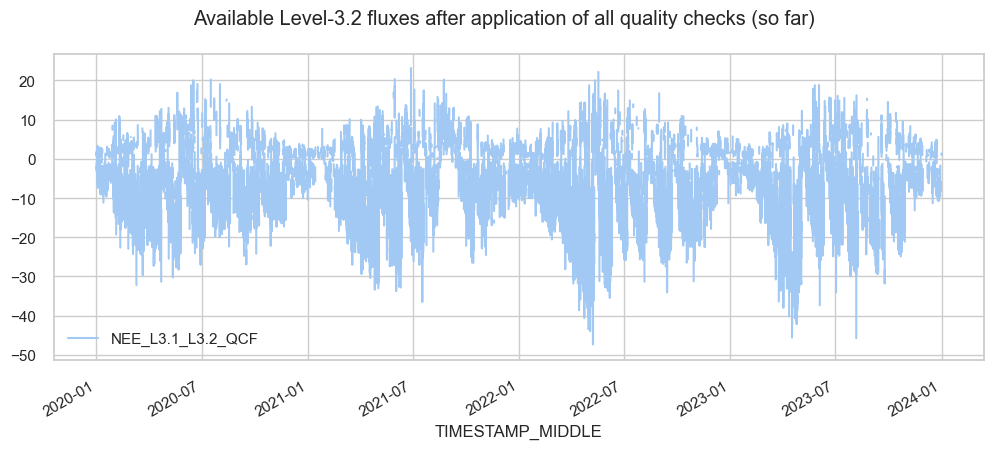

In [151]:
_subset.plot(subplots=True, x_compat=True,
             title="Available Level-3.2 fluxes after application of all quality checks (so far)", figsize=(12, 4.5));

In [152]:
boxplots_df = fpc.fpc_df[[FLUXVAR32QCF, "DAYTIME"]].copy()
boxplots_df["MONTH"] = boxplots_df.index.month
boxplots_df

NEE_L3.1_L3.2_QCF  DAYTIME  MONTH
TIMESTAMP_MIDDLE                                      
2020-01-01 00:15:00                NaN      0.0      1
2020-01-01 00:45:00           1.492641      0.0      1
2020-01-01 01:15:00                NaN      0.0      1
2020-01-01 01:45:00                NaN      0.0      1
2020-01-01 02:15:00           0.483683      0.0      1
...                                ...      ...    ...
2023-12-31 22:45:00                NaN      0.0     12
2023-12-31 23:15:00           1.190371      0.0     12
2023-12-31 23:45:00           1.334124      0.0     12
2024-01-01 00:15:00           1.414890      0.0      1
2024-01-01 00:45:00           1.024868      0.0      1

[70130 rows x 3 columns]

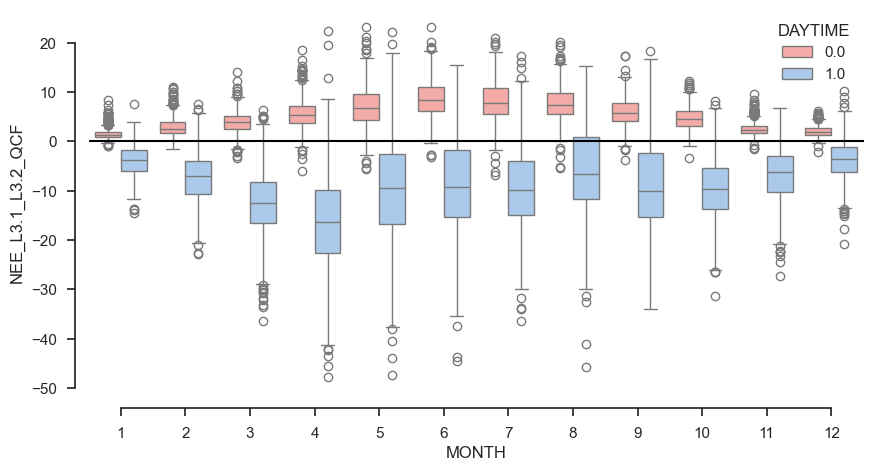

In [153]:
# Draw boxplots
sns.set_theme(style="ticks", palette="pastel")
plt.figure(figsize=(10, 5))
sns.boxplot(x="MONTH", y=FLUXVAR32QCF, palette=["r", "b"], hue="DAYTIME", data=boxplots_df)
sns.despine(offset=10, trim=True)
plt.axhline(0, color="black");

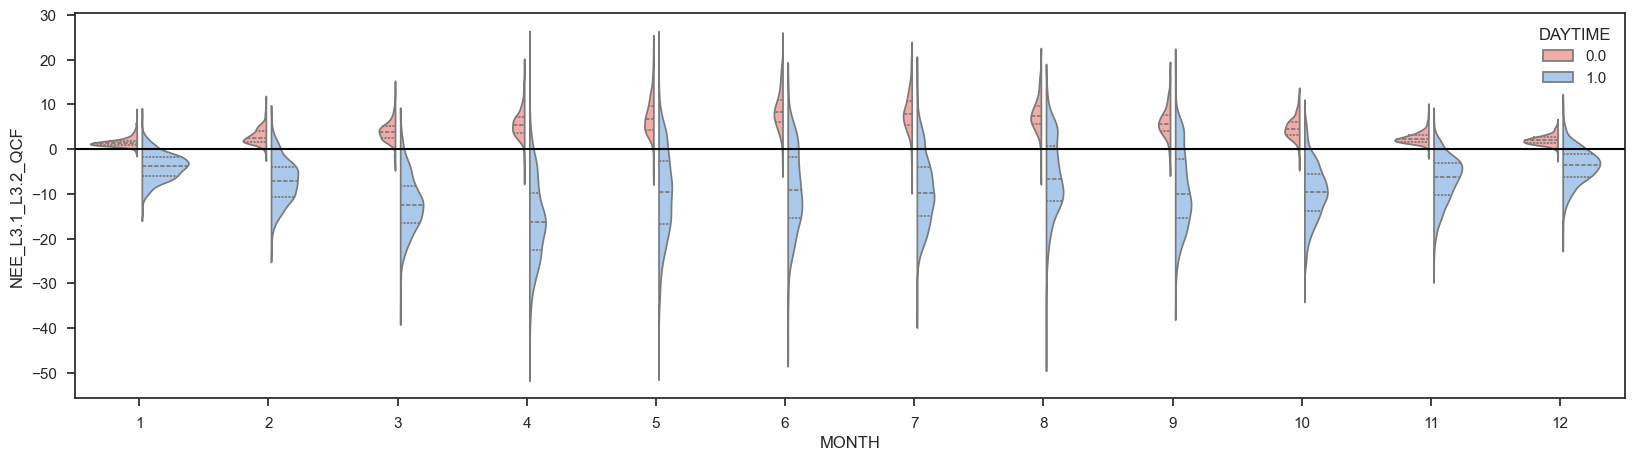

In [154]:
# Draw a nested violinplot and split the violins for easier comparison
plt.figure(figsize=(20, 5))
sns.violinplot(data=boxplots_df, x="MONTH", y=FLUXVAR32QCF, hue="DAYTIME", split=True, palette=["r", "b"], gap=.1, inner="quart");
plt.axhline(0, color="black");

</br>

</br>

# Save results to file
- Save results to file for futher processing
- This can be useful if you want to use the data in another software, e.g. continuing post-processing using the library `ReddyProc` in `R` 
- `Parquet` format is recommended for large datasets

</br>

## Option 1: Save to CSV (large and slow)

In [155]:
# maindf2.to_csv("FluxProcessingChain_L3.2.csv")

</br>

## Option 2: Save to Parquet (small and fast)
- Needed if you want to continue post-processing in notebooks
- Can also be used in `R` with the `arrow` package

In [156]:
save_parquet(data=maindf2, filename="FluxProcessingChain_L3.2")

Saved file FluxProcessingChain_L3.2.parquet (1.280 seconds).


'FluxProcessingChain_L3.2.parquet'

</br>

# **USTAR FILTERING** (Level-3.3) (preliminary, under construction)

<div class="alert alert-block alert-danger">
    No USTAR filtering for: <b>H, LE, ET and FH2O.</b> 
</div>

> The USTAR filtering is not applied to H and LE, because it has not been proved that when there are CO2 advective fluxes, these also impact energy fluxes, specifically due to the fact that when advection is in general large (nighttime), energy fluxes are small.

source: [Pastorello et al. (2020). The FLUXNET2015 dataset and the ONEFlux processing pipeline for eddy covariance data](https://doi.org/10.1038/s41597-020-0534-3)



## *(Preliminary) Impact of different USTAR thresholds on data availability*

[UstarThresholdConstantScenarios]  running UstarThresholdConstantScenarios ...


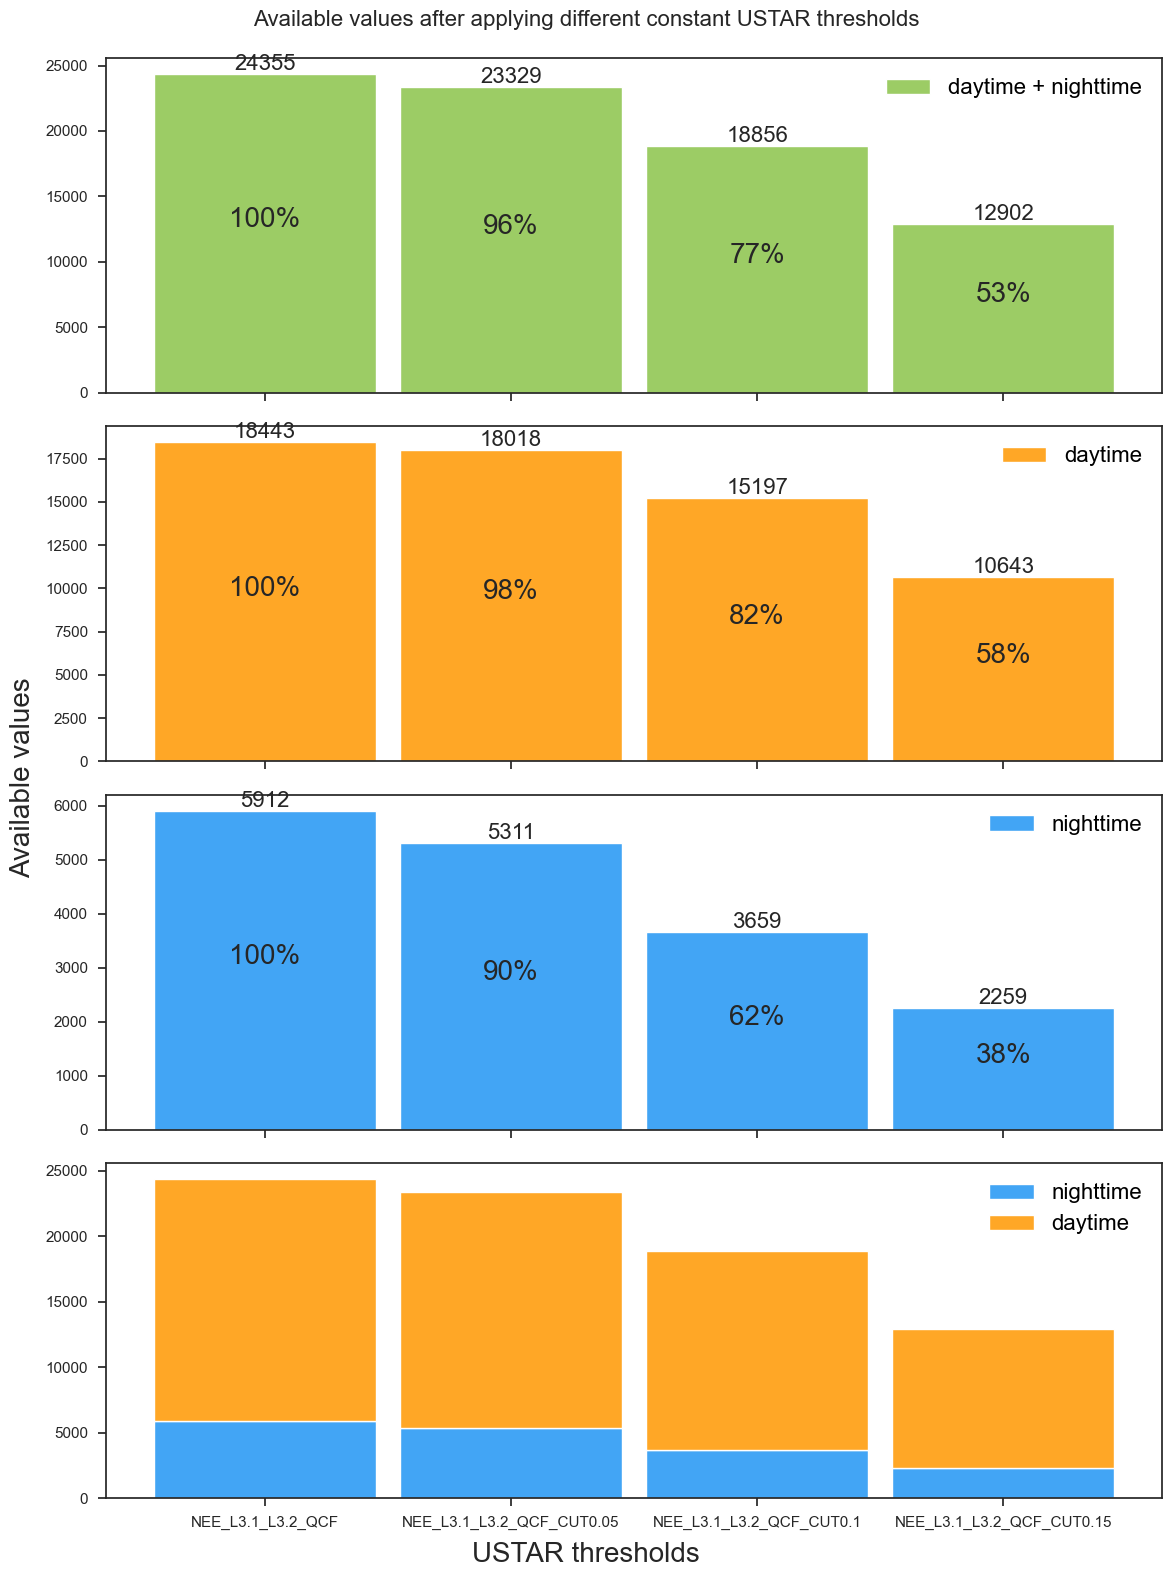

In [157]:
from diive.pkgs.flux.ustarthreshold import UstarThresholdConstantScenarios

ust = UstarThresholdConstantScenarios(series=maindf2[FLUXVAR32QCF],
                                      swinpot=maindf2['SW_IN_POT'],
                                      ustar=maindf['USTAR'])
ust.calc(ustarthresholds=[0.05, 0.1, 0.15], showplot=True, verbose=True)

## *(Preliminary) Apply constant USTAR threshold*
- Use constant USTAR threshold for all data

(TODO)

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [158]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-09-08 18:32:15
